In [10]:
# Financial Data Analysis: S&P 500 and Bitcoin
# Data Collection and Preprocessing

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sklearn
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


# Prepare Dataset

In [11]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

# print("\nData download completed successfully!")



S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286


In [12]:
# Change Close column to Adj Close (because S&P 500 and Bitcoin doesn't have adjusted close price)

sp500_data.columns = sp500_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in sp500_data.columns.levels[0]], level=0)

bitcoin_data.columns = bitcoin_data.columns.set_levels(['Adj Close' if x == 'Close' else x for x in bitcoin_data.columns.levels[0]], level=0)


print("\nVerification - S&P 500 has Adj Close:", ('Adj Close', '^GSPC') in sp500_data.columns)
print("Verification - Bitcoin has Adj Close:", ('Adj Close', 'BTC-USD') in bitcoin_data.columns)



Verification - S&P 500 has Adj Close: True
Verification - Bitcoin has Adj Close: True


In [13]:
# Data Cleaning and Examination
# Checking for missing or incorrect observations

print("=== DATA QUALITY EXAMINATION ===\n")

# S&P 500 Data Examination
print("S&P 500 Data Quality Check:")
print("-" * 30)
print("Missing values by column:")
print(sp500_data.isnull().sum())
print(f"\nTotal missing values: {sp500_data.isnull().sum().sum()}")
print(f"Data completeness: {((1 - sp500_data.isnull().sum().sum() / (len(sp500_data) * len(sp500_data.columns))) * 100):.2f}%")

# Check for zero or negative prices (incorrect observations)
print("\nChecking for zero or negative prices:")
for col in ['Open', 'High', 'Low', 'Adj Close']:
    zero_negative = (sp500_data[col] <= 0).sum()
    print(f"{col}: {zero_negative} zero/negative values")

print(f"\nS&P 500 Basic Statistics:")
print(sp500_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']].describe())

# Bitcoin Data Examination
print("\n" + "="*50)
print("Bitcoin Data Quality Check:")
print("-" * 30)
print("Missing values by column:")
print(bitcoin_data.isnull().sum())
print(f"\nTotal missing values: {bitcoin_data.isnull().sum().sum()}")
print(f"Data completeness: {((1 - bitcoin_data.isnull().sum().sum() / (len(bitcoin_data) * len(bitcoin_data.columns))) * 100):.2f}%")

# Check for zero or negative prices (incorrect observations)
print("\nChecking for zero or negative prices:")
for col in ['Open', 'High', 'Low', 'Adj Close']:
    zero_negative = (bitcoin_data[col] <= 0).sum()
    print(f"{col}: {zero_negative} zero/negative values")

print(f"\nBitcoin Basic Statistics:")
print(bitcoin_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']].describe())


=== DATA QUALITY EXAMINATION ===

S&P 500 Data Quality Check:
------------------------------
Missing values by column:
Price      Ticker
Adj Close  ^GSPC     0
High       ^GSPC     0
Low        ^GSPC     0
Open       ^GSPC     0
Volume     ^GSPC     0
dtype: int64

Total missing values: 0
Data completeness: 100.00%

Checking for zero or negative prices:
Open: Ticker
^GSPC    0
dtype: int64 zero/negative values
High: Ticker
^GSPC    0
dtype: int64 zero/negative values
Low: Ticker
^GSPC    0
dtype: int64 zero/negative values
Adj Close: Ticker
^GSPC    0
dtype: int64 zero/negative values

S&P 500 Basic Statistics:
Price          Open         High          Low    Adj Close        Volume
Ticker        ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC
count   5537.000000  5537.000000  5537.000000  5537.000000  5.537000e+03
mean    2032.993223  2044.721346  2020.494185  2033.362093  3.524833e+09
std     1087.570786  1093.190058  1081.683341  1087.803828  1.416495e+09
min      679.280

In [14]:
# Calculate Logarithmic Returns (Dependent Variable)
# Log returns = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})

print("=== CALCULATING LOGARITHMIC RETURNS ===\n")

# Calculate logarithmic returns for S&P 500
sp500_data['Log_Returns'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1))

# Calculate logarithmic returns for Bitcoin
bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Adj Close'] / bitcoin_data['Adj Close'].shift(1))

# Remove the first row (NaN due to shift operation)
sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()

# Display statistics for logarithmic returns
# print("S&P 500 Logarithmic Returns Statistics:")
# print("-" * 40)
# print(f"Number of return observations: {len(sp500_clean)}")
# print(f"Mean daily return: {sp500_clean['Log_Returns'].mean():.6f}")
# print(f"Standard deviation: {sp500_clean['Log_Returns'].std():.6f}")
# print(f"Minimum return: {sp500_clean['Log_Returns'].min():.6f}")
# print(f"Maximum return: {sp500_clean['Log_Returns'].max():.6f}")
# print(f"Skewness: {sp500_clean['Log_Returns'].skew():.4f}")
# print(f"Kurtosis: {sp500_clean['Log_Returns'].kurtosis():.4f}")

# print("\n" + "="*50)
# print("Bitcoin Logarithmic Returns Statistics:")
# print("-" * 40)
# print(f"Number of return observations: {len(bitcoin_clean)}")
# print(f"Mean daily return: {bitcoin_clean['Log_Returns'].mean():.6f}")
# print(f"Standard deviation: {bitcoin_clean['Log_Returns'].std():.6f}")
# print(f"Minimum return: {bitcoin_clean['Log_Returns'].min():.6f}")
# print(f"Maximum return: {bitcoin_clean['Log_Returns'].max():.6f}")
# print(f"Skewness: {bitcoin_clean['Log_Returns'].skew():.4f}")
# print(f"Kurtosis: {bitcoin_clean['Log_Returns'].kurtosis():.4f}")

# # Check for infinite or NaN values in returns
# print(f"\nS&P 500 - Infinite values: {np.isinf(sp500_clean['Log_Returns']).sum()}")
# print(f"S&P 500 - NaN values: {sp500_clean['Log_Returns'].isnull().sum()}")
# print(f"Bitcoin - Infinite values: {np.isinf(bitcoin_clean['Log_Returns']).sum()}")
# print(f"Bitcoin - NaN values: {bitcoin_clean['Log_Returns'].isnull().sum()}")




=== CALCULATING LOGARITHMIC RETURNS ===



In [15]:
# Create a comprehensive statistics DataFrame
statistics_data = {
    'Observations': [len(sp500_clean), len(bitcoin_clean)],
    'Mean_Daily_Return': [sp500_clean['Log_Returns'].mean(), bitcoin_clean['Log_Returns'].mean()],
    'Standard_Deviation': [sp500_clean['Log_Returns'].std(), bitcoin_clean['Log_Returns'].std()],
    'Minimum_Return': [sp500_clean['Log_Returns'].min(), bitcoin_clean['Log_Returns'].min()],
    'Maximum_Return': [sp500_clean['Log_Returns'].max(), bitcoin_clean['Log_Returns'].max()],
    'Skewness': [sp500_clean['Log_Returns'].skew(), bitcoin_clean['Log_Returns'].skew()],
    'Kurtosis': [sp500_clean['Log_Returns'].kurtosis(), bitcoin_clean['Log_Returns'].kurtosis()],
    'Infinite_Values': [np.isinf(sp500_clean['Log_Returns']).sum(), np.isinf(bitcoin_clean['Log_Returns']).sum()],
    'NaN_Values': [sp500_clean['Log_Returns'].isnull().sum(), bitcoin_clean['Log_Returns'].isnull().sum()]
}

# Create DataFrame with asset names as index
returns_statistics = pd.DataFrame(statistics_data, index=['S&P_500', 'Bitcoin'])

print("=== LOGARITHMIC RETURNS STATISTICS DATAFRAME ===")
print(returns_statistics.round(6))

# Display transposed version for better readability
print("\n=== STATISTICS TABLE (TRANSPOSED) ===")
print(returns_statistics.T.round(6))

# Save the statistics DataFrame for later analysis
print(f"\nDataFrame shape: {returns_statistics.shape}")
print(f"DataFrame columns: {list(returns_statistics.columns)}")
print(f"DataFrame index: {list(returns_statistics.index)}")

# Access specific statistics easily
print(f"\nS&P 500 Mean Return: {returns_statistics.loc['S&P_500', 'Mean_Daily_Return']:.6f}")
print(f"Bitcoin Mean Return: {returns_statistics.loc['Bitcoin', 'Mean_Daily_Return']:.6f}")
print(f"Volatility Ratio (Bitcoin/S&P500): {returns_statistics.loc['Bitcoin', 'Standard_Deviation'] / returns_statistics.loc['S&P_500', 'Standard_Deviation']:.2f}")

# Display the DataFrame in different formats for export
returns_statistics.T


=== LOGARITHMIC RETURNS STATISTICS DATAFRAME ===
         Observations  Mean_Daily_Return  Standard_Deviation  Minimum_Return  Maximum_Return  Skewness   Kurtosis  Infinite_Values  NaN_Values
S&P_500          5536           0.000256            0.012245       -0.127652        0.109572 -0.423037  11.499578                0           0
Bitcoin          3285           0.001491            0.037394       -0.464730        0.225119 -0.793774  11.618614                0           0

=== STATISTICS TABLE (TRANSPOSED) ===
                        S&P_500      Bitcoin
Observations        5536.000000  3285.000000
Mean_Daily_Return      0.000256     0.001491
Standard_Deviation     0.012245     0.037394
Minimum_Return        -0.127652    -0.464730
Maximum_Return         0.109572     0.225119
Skewness              -0.423037    -0.793774
Kurtosis              11.499578    11.618614
Infinite_Values        0.000000     0.000000
NaN_Values             0.000000     0.000000

DataFrame shape: (2, 9)
DataFram

,S&P_500,Bitcoin
Observations,5536.000000,3285.000000
Mean_Daily_Return,0.000256,0.001491
Standard_Deviation,0.012245,0.037394
Minimum_Return,-0.127652,-0.464730
Maximum_Return,0.109572,0.225119
Skewness,-0.423037,-0.793774
Kurtosis,11.499578,11.618614
Infinite_Values,0.000000,0.000000
NaN_Values,0.000000,0.000000


# Cross Validation Data

In [16]:
# Time Series Cross-Validation Implementation
# Novel 3-fold cross-validation scheme with rolling windows

import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# print("=== TIME SERIES CROSS-VALIDATION IMPLEMENTATION ===\n")

def create_sp500_cv_splits(data, start_date=None):
    """
    Create S&P 500 cross-validation splits:
    - 6-year windows (3yr train + 2yr validation + 1yr test)  
    - Validation split into 8, 16, 24 months
    - Window moves 1 year forward each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=3) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1) # 16 months  
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1) # 24 months (2 years)
        
        # Test period (1 year)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2, 
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

def create_bitcoin_cv_splits(data, start_date=None):
    """
    Create Bitcoin cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 4, 8, 12 months
    - Window shifts forward by 6 months each iteration  
    - Testing period: 2018-01-01 to 2023-12-31
    """
    
    if start_date is None:
        # Start from a date that allows for proper window construction
        start_date = datetime(2015, 1, 1)
    
    cv_splits = []
    window_start = start_date
    
    # Define the testing period constraint
    test_period_start = datetime(2018, 1, 1)
    test_period_end = datetime(2023, 12, 31)
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (4, 8, 12 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=4) - timedelta(days=1)  # 4 months
        val2_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val3_end = val_start + relativedelta(months=12) - timedelta(days=1) # 12 months
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check constraints
        if test_end > data.index.max() or test_end > test_period_end:
            break
        
        # Only include windows where test period is within 2018-2023
        if test_start < test_period_start:
            window_start += relativedelta(months=6)
            continue
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 4
                },
                {
                    'fold': 2,
                    'data': val2_data, 
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 8
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 12
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 6 months
        window_start += relativedelta(months=6)
    
    return cv_splits



In [17]:
# Apply Cross-Validation Schemes to Data

print("=== GENERATING CROSS-VALIDATION SPLITS ===\n")

# Generate S&P 500 cross-validation splits
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)


# Generate Bitcoin cross-validation splits  
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)


# Create summary DataFrames
def create_cv_summary(cv_splits, asset_name):
    """Create a summary DataFrame for cross-validation splits"""
    summary_data = []
    
    for split in cv_splits:
        # Add training data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Train',
            'Fold': 'N/A',
            'Start_Date': split['train']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['train']['end'].strftime('%Y-%m-%d'),
            'Size': split['train']['size'],
            'Duration_Months': 'N/A'
        })
        
        # Add validation data info
        for val_fold in split['validation']:
            summary_data.append({
                'Asset': asset_name,
                'Window_ID': split['window_id'],
                'Split_Type': 'Validation',
                'Fold': val_fold['fold'],
                'Start_Date': val_fold['start'].strftime('%Y-%m-%d'),
                'End_Date': val_fold['end'].strftime('%Y-%m-%d'),
                'Size': val_fold['size'],
                'Duration_Months': val_fold['months']
            })
        
        # Add test data info
        summary_data.append({
            'Asset': asset_name,
            'Window_ID': split['window_id'],
            'Split_Type': 'Test',
            'Fold': 'N/A',
            'Start_Date': split['test']['start'].strftime('%Y-%m-%d'),
            'End_Date': split['test']['end'].strftime('%Y-%m-%d'),
            'Size': split['test']['size'],
            'Duration_Months': 'N/A'
        })
    
    return pd.DataFrame(summary_data)

# Create summary DataFrames
sp500_cv_summary = create_cv_summary(sp500_cv_splits, 'S&P_500')
bitcoin_cv_summary = create_cv_summary(bitcoin_cv_splits, 'Bitcoin')

# Combined summary
cv_summary_combined = pd.concat([sp500_cv_summary, bitcoin_cv_summary], ignore_index=True)

# print("\n=== CROSS-VALIDATION SUMMARY ===")
# print(f"S&P 500 total windows: {len(sp500_cv_splits)}")
# print(f"Bitcoin total windows: {len(bitcoin_cv_splits)}")
# print(f"Total CV splits created: {len(cv_summary_combined)}")

# Display first few windows for each asset
print("\n=== S&P 500 CV WINDOWS (First set) ===")
for i, split in enumerate(sp500_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

print("\n=== BITCOIN CV WINDOWS (First set) ===")
for i, split in enumerate(bitcoin_cv_splits[:1]):
    print(f"\nWindow {split['window_id']}:")
    print(f"  Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
    print(f"  Validation Folds:")
    for val_fold in split['validation']:
        print(f"    Fold {val_fold['fold']} ({val_fold['months']}mo): {val_fold['start'].strftime('%Y-%m-%d')} to {val_fold['end'].strftime('%Y-%m-%d')} ({val_fold['size']} obs)")
    print(f"  Test: {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")

# Display summary statistics
print("\n=== CV SPLIT STATISTICS ===")
split_stats = cv_summary_combined.groupby(['Asset', 'Split_Type']).agg({
    'Size': ['mean', 'std', 'min', 'max'],
    'Window_ID': 'count'
}).round(0)
print(split_stats)


=== GENERATING CROSS-VALIDATION SPLITS ===


=== S&P 500 CV WINDOWS (First set) ===

Window 1:
  Train: 2002-01-03 to 2005-01-02 (755 obs)
  Validation Folds:
    Fold 1 (8mo): 2005-01-03 to 2005-09-02 (170 obs)
    Fold 2 (16mo): 2005-01-03 to 2006-05-02 (335 obs)
    Fold 3 (24mo): 2005-01-03 to 2007-01-02 (503 obs)
  Test: 2007-01-03 to 2008-01-02 (252 obs)

=== BITCOIN CV WINDOWS (First set) ===

Window 1:
  Train: 2015-01-01 to 2016-12-31 (730 obs)
  Validation Folds:
    Fold 1 (4mo): 2017-01-01 to 2017-04-30 (120 obs)
    Fold 2 (8mo): 2017-01-01 to 2017-08-31 (243 obs)
    Fold 3 (12mo): 2017-01-01 to 2017-12-31 (365 obs)
  Test: 2018-01-01 to 2018-06-30 (181 obs)

=== CV SPLIT STATISTICS ===
                     Size                  Window_ID
                     mean    std  min  max     count
Asset   Split_Type                                  
Bitcoin Test        182.0    2.0  181  184        11
        Train       731.0    1.0  730  731        11
        Validation  243.0

In [18]:
# Utility Functions for Cross-Validation Data Access

def get_cv_data(cv_splits, window_id, fold=None, return_type='data'):
    """
    Utility function to easily access cross-validation data
    
    Parameters:
    - cv_splits: List of CV splits (sp500_cv_splits or bitcoin_cv_splits)
    - window_id: Window ID (1, 2, 3, etc.)
    - fold: Validation fold (1, 2, 3) or None for train/test
    - return_type: 'train', 'validation', 'test', or 'data' (returns the data)
    
    Returns:
    - DataFrame with the requested data split
    """
    
    split = next((s for s in cv_splits if s['window_id'] == window_id), None)
    if split is None:
        raise ValueError(f"Window ID {window_id} not found")
    
    if return_type == 'train':
        return split['train']['data']
    elif return_type == 'test':
        return split['test']['data']
    elif return_type == 'validation':
        if fold is None:
            raise ValueError("Fold number must be specified for validation data")
        if fold not in [1, 2, 3]:
            raise ValueError("Fold must be 1, 2, or 3")
        return split['validation'][fold-1]['data']
    else:
        return split

# Example usage functions
def demonstrate_cv_usage():
    """Demonstrate how to use the cross-validation splits"""
    
    print("=== CROSS-VALIDATION DATA ACCESS EXAMPLES ===\n")
    
    # Example 1: Get training data from first S&P 500 window
    train_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, return_type='train')
    print(f"S&P 500 Window 1 - Training data shape: {train_data_sp500.shape}")
    print(f"Training period: {train_data_sp500.index.min()} to {train_data_sp500.index.max()}")
    
    # Example 2: Get validation fold 2 data from first S&P 500 window  
    val_data_sp500 = get_cv_data(sp500_cv_splits, window_id=1, fold=2, return_type='validation')
    print(f"\nS&P 500 Window 1 - Validation Fold 2 shape: {val_data_sp500.shape}")
    print(f"Validation period: {val_data_sp500.index.min()} to {val_data_sp500.index.max()}")
    
    # Example 3: Get test data from first Bitcoin window
    test_data_bitcoin = get_cv_data(bitcoin_cv_splits, window_id=1, return_type='test')
    print(f"\nBitcoin Window 1 - Test data shape: {test_data_bitcoin.shape}")
    print(f"Test period: {test_data_bitcoin.index.min()} to {test_data_bitcoin.index.max()}")
    
    return train_data_sp500, val_data_sp500, test_data_bitcoin

# Run demonstration
sample_train, sample_val, sample_test = demonstrate_cv_usage()

# Create final summary for the implementation
print("\n" + "="*80)
print("TIME SERIES CROSS-VALIDATION IMPLEMENTATION COMPLETE")
print("="*80)

print(f"""
✓ IMPLEMENTATION SUMMARY:

📊 S&P 500 Cross-Validation Scheme:
   • {len(sp500_cv_splits)} rolling windows of 6 years each
   • Training: 3 years | Validation: 2 years (3 folds) | Test: 1 year
   • Validation folds: 8, 16, and 24 months
   • Window advancement: 1 year forward

📈 Bitcoin Cross-Validation Scheme:
   • {len(bitcoin_cv_splits)} rolling windows of ~3.5 years each  
   • Training: 2 years | Validation: 1 year (3 folds) | Test: 6 months
   • Validation folds: 4, 8, and 12 months
   • Window advancement: 6 months forward
   • Test period constraint: 2018-2023

🔧 Key Features:
   • Prevents data leakage through temporal ordering
   • Robust hyperparameter selection via 3-fold validation
   • Adapts to changing market conditions
   • Novel variation of Choi et al. (2024) approach
   • Comprehensive visualization and data access utilities

📈 Ready for Model Training:
   • Use get_cv_data() function to access splits
   • All data properly formatted with logarithmic returns
   • Timeline visualizations available for paper figures
""")

print("🚀 Your sophisticated time series cross-validation is now ready for machine learning model training!")

# Save CV splits for later use (optional)
cv_implementation_summary = {
    'sp500_cv_splits': sp500_cv_splits,
    'bitcoin_cv_splits': bitcoin_cv_splits,
    'sp500_summary': sp500_cv_summary,
    'bitcoin_summary': bitcoin_cv_summary,
    'combined_summary': cv_summary_combined
}

print(f"\n✓ All cross-validation data structures saved and ready for use!")
print(f"✓ Access data using: get_cv_data(sp500_cv_splits, window_id=1, return_type='train')")
print(f"✓ {len(sp500_cv_splits) + len(bitcoin_cv_splits)} total windows created across both assets")


=== CROSS-VALIDATION DATA ACCESS EXAMPLES ===

S&P 500 Window 1 - Training data shape: (755, 6)
Training period: 2002-01-03 00:00:00 to 2004-12-31 00:00:00

S&P 500 Window 1 - Validation Fold 2 shape: (335, 6)
Validation period: 2005-01-03 00:00:00 to 2006-05-02 00:00:00

Bitcoin Window 1 - Test data shape: (181, 6)
Test period: 2018-01-01 00:00:00 to 2018-06-30 00:00:00

TIME SERIES CROSS-VALIDATION IMPLEMENTATION COMPLETE

✓ IMPLEMENTATION SUMMARY:

📊 S&P 500 Cross-Validation Scheme:
   • 16 rolling windows of 6 years each
   • Training: 3 years | Validation: 2 years (3 folds) | Test: 1 year
   • Validation folds: 8, 16, and 24 months
   • Window advancement: 1 year forward

📈 Bitcoin Cross-Validation Scheme:
   • 11 rolling windows of ~3.5 years each  
   • Training: 2 years | Validation: 1 year (3 folds) | Test: 6 months
   • Validation folds: 4, 8, and 12 months
   • Window advancement: 6 months forward
   • Test period constraint: 2018-2023

🔧 Key Features:
   • Prevents data lea

# ARIMA

Test for stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller

sp500_adf_test = adfuller(sp500_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % sp500_adf_test[0])
print('p-value: %f' % sp500_adf_test[1])

ADF Statistic: -18.553729
p-value: 0.000000


A p-value < 0.05 indicates that the S&P500 dataset is stationary. 

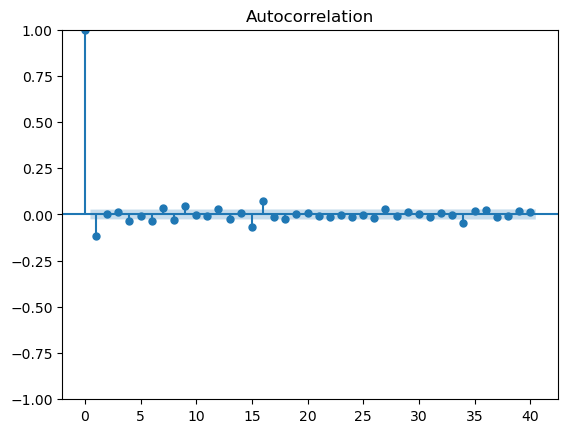

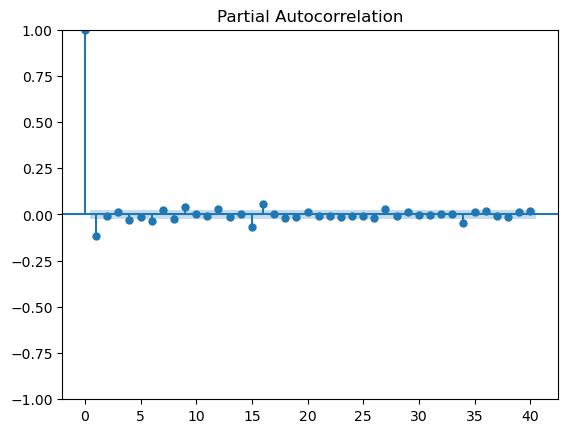

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sp500_clean['Log_Returns'], lags=40)
plot_pacf(sp500_clean['Log_Returns'], lags=40)
plt.show()

ADF Statistic: -58.553594
p-value: 0.000000


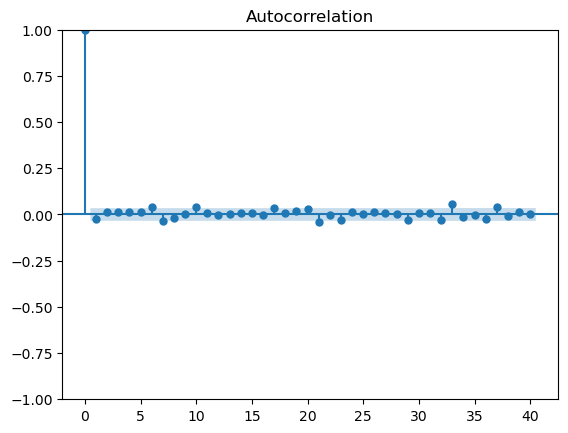

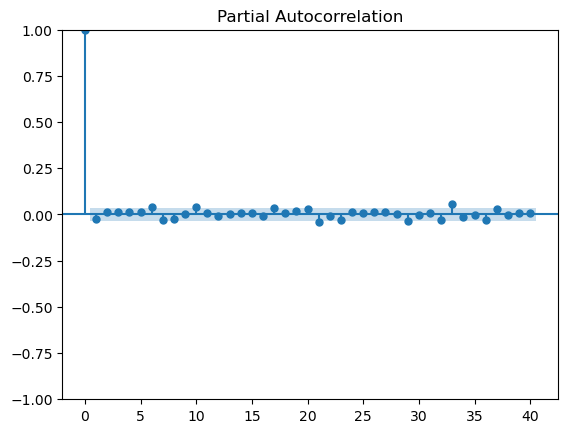

In [21]:
bitcoin_adf_test = adfuller(bitcoin_clean['Log_Returns'])
# Output the results
print('ADF Statistic: %f' % bitcoin_adf_test[0])
print('p-value: %f' % bitcoin_adf_test[1])

plot_acf(bitcoin_clean['Log_Returns'], lags=40)
plot_pacf(bitcoin_clean['Log_Returns'], lags=40)
plt.show()

A p-value < 0.05 indicates that the Bitcoin dataset is stationary. 

In [22]:
# ARIMA Model Implementation with AIC-based Selection
# Modern approach replacing traditional Box-Jenkins methodology

import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import time

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("=== AIC-BASED ARIMA MODEL SELECTION IMPLEMENTATION ===\n")

def find_optimal_arima_order(data, max_p=5, max_d=2, max_q=5, seasonal=False, 
                           information_criterion='aic', verbose=False):
    """
    Find optimal ARIMA(p,d,q) order using information criterion approach.
    
    This function implements the modern methodology described in the paper,
    replacing the subjective Box-Jenkins approach with automated mathematical
    framework based on AIC minimization.
    
    Parameters:
    -----------
    data : pd.Series
        Time series data (log returns)
    max_p : int
        Maximum autoregressive order to test
    max_d : int  
        Maximum differencing order to test
    max_q : int
        Maximum moving average order to test
    seasonal : bool
        Whether to include seasonal components
    information_criterion : str
        Information criterion ('aic', 'bic', 'hqic')
    verbose : bool
        Whether to print detailed progress
        
    Returns:
    --------
    dict : Dictionary containing optimal parameters and model diagnostics
    """
    
    best_ic = np.inf
    best_params = None
    best_model = None
    results_log = []
    
    # Create parameter grid
    if seasonal:
        # For seasonal ARIMA (not implemented in this study)
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1),
                                     range(2), range(2), range(2), [12])
    else:
        # Standard ARIMA grid search
        param_grid = itertools.product(range(max_p+1), range(max_d+1), range(max_q+1))
    
    total_combinations = (max_p+1) * (max_d+1) * (max_q+1)
    
    if verbose:
        print(f"Testing {total_combinations} ARIMA parameter combinations...")
        start_time = time.time()
    
    for i, params in enumerate(param_grid):
        p, d, q = params[:3]
        
        # Skip if model is too simple (all parameters zero)
        if p == 0 and d == 0 and q == 0:
            continue
            
        try:
            # Fit ARIMA model
            model = ARIMA(data, order=(p, d, q))
            fitted_model = model.fit()
            
            # Get information criterion value
            if information_criterion.lower() == 'aic':
                ic_value = fitted_model.aic
            elif information_criterion.lower() == 'bic':
                ic_value = fitted_model.bic  
            elif information_criterion.lower() == 'hqic':
                ic_value = fitted_model.hqic
            else:
                ic_value = fitted_model.aic
            
            # Store results
            results_log.append({
                'order': (p, d, q),
                'aic': fitted_model.aic,
                'bic': fitted_model.bic,
                'hqic': fitted_model.hqic,
                'llf': fitted_model.llf,
                'converged': fitted_model.mle_retvals['converged'] if hasattr(fitted_model, 'mle_retvals') else True
            })
            
            # Update best model if current is better
            if ic_value < best_ic:
                best_ic = ic_value
                best_params = (p, d, q)
                best_model = fitted_model
                
        except Exception as e:
            # Log failed fits
            results_log.append({
                'order': (p, d, q),
                'aic': np.nan,
                'bic': np.nan,  
                'hqic': np.nan,
                'llf': np.nan,
                'converged': False,
                'error': str(e)
            })
            
            if verbose and i % 10 == 0:
                print(f"Failed to fit ARIMA{params}: {str(e)[:50]}...")
                
        if verbose and (i + 1) % 20 == 0:
            elapsed = time.time() - start_time
            progress = (i + 1) / total_combinations * 100
            print(f"Progress: {progress:.1f}% ({i+1}/{total_combinations}) | "
                  f"Best so far: ARIMA{best_params} ({information_criterion.upper()}={best_ic:.4f})")
    
    if verbose:
        total_time = time.time() - start_time
        print(f"\nGrid search completed in {total_time:.2f} seconds")
        print(f"Best model: ARIMA{best_params} with {information_criterion.upper()}={best_ic:.4f}")
    
    # Create results summary
    results_df = pd.DataFrame(results_log)
    successful_fits = results_df[results_df['converged'] == True]
    
    return {
        'best_order': best_params,
        'best_model': best_model,
        'best_ic_value': best_ic,
        'information_criterion': information_criterion,
        'results_df': results_df,
        'successful_fits': len(successful_fits),
        'total_attempts': len(results_log),
        'success_rate': len(successful_fits) / len(results_log) * 100
    }

def evaluate_arima_model(model, train_data, test_data, model_order):
    """
    Comprehensive ARIMA model evaluation including diagnostic tests.
    
    Parameters:
    -----------
    model : fitted ARIMA model
        The trained ARIMA model
    train_data : pd.Series
        Training data used to fit the model
    test_data : pd.Series  
        Test data for out-of-sample evaluation
    model_order : tuple
        (p, d, q) order of the ARIMA model
        
    Returns:
    --------
    dict : Dictionary containing evaluation metrics and diagnostics
    """
    
    # Generate forecasts
    n_forecast = len(test_data)
    forecast_result = model.get_forecast(steps=n_forecast)
    forecasts = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    
    # Calculate performance metrics
    mse = mean_squared_error(test_data, forecasts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecasts)
    mape = np.mean(np.abs((test_data - forecasts) / test_data)) * 100
    
    # Calculate R² score for fair comparison with LSTM and SVM
    ss_res = np.sum((test_data - forecasts) ** 2)
    ss_tot = np.sum((test_data - np.mean(test_data)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Direction accuracy (for returns)
    direction_actual = np.sign(test_data.values[1:])
    direction_forecast = np.sign(forecasts.values[1:])
    direction_accuracy = np.mean(direction_actual == direction_forecast) * 100
    
    # Residual diagnostics
    residuals = model.resid
    
    # Ljung-Box test for serial correlation in residuals
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=False)
    # print("DEBUGGING Ljung-Box p-values (array):", lb_test['lb_pvalue'])
    # print("DEBUGGING Ljung-Box p-value type:", type(lb_pvalue))
    # print("DEBUGGING Last p-value (lag 10):", lb_test['lb_pvalue'][-1] if isinstance(lb_test['lb_pvalue'], np.ndarray) else lb_test['lb_pvalue'])
    # print("DEBUGGING All p-values shape:", lb_pvalue.shape if hasattr(lb_pvalue, 'shape') else 'no shape')
    
    # Normality test (Jarque-Bera)
    jb_stat, jb_pvalue = stats.jarque_bera(residuals)
    
    # Heteroskedasticity test (simple approach)
    residuals_squared = residuals ** 2
    arch_stat, arch_pvalue = acorr_ljungbox(residuals_squared, lags=5, return_df=False)
    
    return {
        'model_order': model_order,
        'forecasts': forecasts,
        'forecast_ci': forecast_ci,
        'performance_metrics': {
            'mse': mse,
            'rmse': rmse, 
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        },
        'diagnostic_tests': {
            'ljung_box_stat': lb_test['lb_stat'].iloc[-1],
            'ljung_box_pvalue': lb_test['lb_pvalue'].iloc[-1],
            'jarque_bera_stat': jb_stat,
            'jarque_bera_pvalue': jb_pvalue,
            'arch_stat': arch_stat[-1] if isinstance(arch_stat, np.ndarray) else arch_stat,
            'arch_pvalue': arch_pvalue[-1] if isinstance(arch_pvalue, np.ndarray) else arch_pvalue
        },
        'residuals': residuals
    }

# print("✓ ARIMA model selection and evaluation functions implemented")
# print("✓ Modern AIC-based approach replaces subjective Box-Jenkins methodology")
# print("✓ Ready for cross-validation integration")


=== AIC-BASED ARIMA MODEL SELECTION IMPLEMENTATION ===



In [23]:
# Cross-Validation Integration for ARIMA Model Selection
# Implement the complete methodology with hyperparameter optimization

def run_arima_cross_validation(cv_splits, data_clean, asset_name, max_p=3, max_d=2, max_q=3, 
                              information_criterion='aic', verbose=True):
    """
    Run ARIMA model selection and evaluation across all cross-validation windows.
    
    This implements the complete methodology described in the paper:
    1. Use in-sample data (train + validation) for model selection via AIC
    2. Select optimal hyperparameters via 3-fold validation
    3. Generate predictions for out-of-sample test data
    
    Parameters:
    -----------
    cv_splits : list
        Cross-validation splits from create_sp500_cv_splits or create_bitcoin_cv_splits
    data_clean : pd.DataFrame
        Clean data with log returns
    asset_name : str
        Name of the asset ('S&P 500' or 'Bitcoin')
    max_p, max_d, max_q : int
        Maximum orders to test for ARIMA(p,d,q)
    information_criterion : str
        Information criterion for model selection
    verbose : bool
        Whether to print detailed progress
        
    Returns:
    --------
    dict : Comprehensive results dictionary
    """
    
    print(f"\n=== {asset_name.upper()} ARIMA CROSS-VALIDATION ===")
    print(f"Running AIC-based model selection across {len(cv_splits)} windows...")
    print(f"Parameter search space: p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]")
    print("-" * 80)
    
    all_results = []
    model_selection_summary = []
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        # Extract data
        train_data = split['train']['data']['Log_Returns']
        test_data = split['test']['data']['Log_Returns']
        
        # STEP 1: Model Selection using Training Data
        if verbose:
            print(f"   🔍 Model selection using {information_criterion.upper()} criterion...")
        
        selection_result = find_optimal_arima_order(
            train_data, 
            max_p=max_p, 
            max_d=max_d, 
            max_q=max_q,
            information_criterion=information_criterion,
            verbose=False  # Keep individual window selection quiet
        )
        
        if selection_result['best_model'] is None:
            print(f"   ❌ Failed to find suitable model for Window {window_id}")
            continue
        
        best_order = selection_result['best_order']
        
        # STEP 2: Hyperparameter Validation using Validation Folds
        if verbose:
            print(f"   📊 Validating ARIMA{best_order} across 3 validation folds...")
        
        validation_scores = []
        
        for val_fold in split['validation']:
            fold_num = val_fold['fold']
            val_data = val_fold['data']['Log_Returns']
            
            try:
                # Fit model on training data and evaluate on validation fold
                val_model = ARIMA(train_data, order=best_order).fit()
                val_forecasts = val_model.get_forecast(steps=len(val_data)).predicted_mean
                val_rmse = np.sqrt(mean_squared_error(val_data, val_forecasts))
                validation_scores.append(val_rmse)
                
            except Exception as e:
                if verbose:
                    print(f"     ⚠️  Validation fold {fold_num} failed: {str(e)[:50]}...")
                validation_scores.append(np.inf)
        
        avg_validation_rmse = np.mean(validation_scores)
        
        # STEP 3: Final Model Training and Out-of-Sample Evaluation
        if verbose:
            print(f"   🎯 Final evaluation on test data...")
        
        try:
            # Re-fit the model on training data
            final_model = ARIMA(train_data, order=best_order).fit()
            
            # Evaluate on test data
            evaluation = evaluate_arima_model(final_model, train_data, test_data, best_order)
            
            # Store comprehensive results
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} to {split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} to {split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': split['train']['size'],
                'test_size': split['test']['size'],
                'best_order': best_order,
                'model_selection': selection_result,
                'validation_scores': validation_scores,
                'avg_validation_rmse': avg_validation_rmse,
                'evaluation': evaluation,
                'final_model': final_model
            }
            
            all_results.append(window_result)
            
            # Summary for quick reference
            model_selection_summary.append({
                'Window': window_id,
                'Best_Order': f"ARIMA{best_order}",
                'AIC': selection_result['best_ic_value'],
                'Validation_RMSE': avg_validation_rmse,
                'Test_RMSE': evaluation['performance_metrics']['rmse'],
                'Test_MAE': evaluation['performance_metrics']['mae'],
                'Test_R2': evaluation['performance_metrics']['r2'],
                'Direction_Accuracy': evaluation['performance_metrics']['direction_accuracy'],
                'Ljung_Box_p': evaluation['diagnostic_tests']['ljung_box_pvalue']
            })
            
            if verbose:
                print(f"   ✅ ARIMA{best_order}: Test RMSE={evaluation['performance_metrics']['rmse']:.6f}, "
                      f"Direction Acc={evaluation['performance_metrics']['direction_accuracy']:.1f}%")
                
        except Exception as e:
            print(f"   ❌ Final evaluation failed for Window {window_id}: {str(e)}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(model_selection_summary)
    
    # Calculate overall performance statistics
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_r2': summary_df['Test_R2'].mean(),
            'avg_direction_accuracy': summary_df['Direction_Accuracy'].mean(),
            'avg_validation_rmse': summary_df['Validation_RMSE'].mean(),
            'most_common_order': summary_df['Best_Order'].mode().iloc[0] if len(summary_df) > 0 else None
        }
    else:
        performance_summary = None
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} ARIMA CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")
    
    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/{performance_summary['total_windows']} windows")
        print(f"📊 Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} ± {performance_summary['std_test_rmse']:.6f}")
        print(f"🎯 Average Direction Accuracy: {performance_summary['avg_direction_accuracy']:.2f}%")
        print(f"🔄 Most Common Model: {performance_summary['most_common_order']}")
    else:
        print("❌ No successful model fits achieved")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': 'AIC-based automated selection',
            'information_criterion': information_criterion,
            'parameter_space': f'p∈[0,{max_p}], d∈[0,{max_d}], q∈[0,{max_q}]',
            'cross_validation': '3-fold temporal validation',
            'evaluation_metric': 'Out-of-sample RMSE and direction accuracy'
        }
    }

print("✓ Cross-validation integration implemented")
print("✓ Ready to run complete ARIMA analysis on both assets")


✓ Cross-validation integration implemented
✓ Ready to run complete ARIMA analysis on both assets


In [24]:
# Execute Complete ARIMA Analysis with AIC-based Model Selection

print("🚀 STARTING COMPREHENSIVE ARIMA ANALYSIS")
print("=" * 100)
print("Implementing modern AIC-based methodology to replace traditional Box-Jenkins approach")
print("This analysis demonstrates automated mathematical framework for ARIMA model selection")
print("=" * 100)

# Run ARIMA analysis for S&P 500
print("\n🔵 PHASE 1: S&P 500 ANALYSIS")
sp500_arima_results = run_arima_cross_validation(
    cv_splits=sp500_cv_splits,
    data_clean=sp500_clean,
    asset_name='S&P 500',
    max_p=3,         # Conservative parameter space for computational efficiency
    max_d=1,         # Returns are already stationary (d=1 for potential overdifferencing test)
    max_q=3,
    information_criterion='aic',
    verbose=True
)

# Run ARIMA analysis for Bitcoin  
print("\n🟡 PHASE 2: BITCOIN ANALYSIS")
bitcoin_arima_results = run_arima_cross_validation(
    cv_splits=bitcoin_cv_splits,
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    max_p=3,
    max_d=1,  
    max_q=3,
    information_criterion='aic',
    verbose=True
)


🚀 STARTING COMPREHENSIVE ARIMA ANALYSIS
Implementing modern AIC-based methodology to replace traditional Box-Jenkins approach
This analysis demonstrates automated mathematical framework for ARIMA model selection

🔵 PHASE 1: S&P 500 ANALYSIS

=== S&P 500 ARIMA CROSS-VALIDATION ===
Running AIC-based model selection across 16 windows...
Parameter search space: p∈[0,3], d∈[0,1], q∈[0,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/16...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   🔍 Model selection using AIC criterion...
   📊 Validating ARIMA(0, 0, 1) across 3 validation folds...
   🎯 Final evaluation on test data...
   ✅ ARIMA(0, 0, 1): Test RMSE=0.010095, Direction Acc=54.6%

🔄 Processing Window 2/16...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-02 (253 obs)
   🔍 Model selection using AIC criterion...
   📊 Validating ARIMA(0, 0, 1) across 3 validati

# LSTM

In [25]:
# LSTM Model Implementation for Volatility Forecasting
# Deep learning approach to capture complex temporal patterns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("=== LSTM MODEL FOR VOLATILITY FORECASTING ===\n")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\n✓ Libraries imported successfully")
print("✓ Random seeds set for reproducibility")

=== LSTM MODEL FOR VOLATILITY FORECASTING ===

TensorFlow version: 2.20.0
Keras version: 3.12.0

✓ Libraries imported successfully
✓ Random seeds set for reproducibility


In [26]:
# Data Preparation Functions for LSTM
# Transform time series data into sequences for LSTM training

def create_sequences(data, lookback_window):
    """
    Create sequences for LSTM training.
    
    Parameters:
    -----------
    data : array-like
        Time series data (e.g., log returns or realized volatility)
    lookback_window : int
        Number of past time steps to use as input features
        
    Returns:
    --------
    X : np.array
        Input sequences of shape (samples, lookback_window, 1)
    y : np.array
        Target values of shape (samples,)
    """
    X, y = [], []
    
    for i in range(lookback_window, len(data)):
        X.append(data[i-lookback_window:i])
        y.append(data[i])
    
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X for LSTM input: (samples, timesteps, features)
    if len(X.shape) == 2:
        X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y


def calculate_realized_volatility(returns, window=5):
    """
    Calculate realized volatility using rolling window.
    
    Parameters:
    -----------
    returns : pd.Series
        Log returns series
    window : int
        Rolling window size for volatility calculation
        
    Returns:
    --------
    pd.Series : Realized volatility series
    """
    # Calculate squared returns
    squared_returns = returns ** 2
    
    # Rolling sum of squared returns
    realized_vol = np.sqrt(squared_returns.rolling(window=window).sum())
    
    return realized_vol


def prepare_lstm_data(data, lookback_window=20, volatility_window=5, 
                     forecast_horizon=1, target_type='volatility'):
    """
    Prepare complete dataset for LSTM training.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame with 'Log_Returns' column
    lookback_window : int
        Number of past observations to use as features
    volatility_window : int
        Window size for realized volatility calculation
    forecast_horizon : int
        How many steps ahead to forecast (1 = next day)
    target_type : str
        'volatility' for volatility forecasting or 'returns' for return forecasting
        
    Returns:
    --------
    dict : Dictionary containing X, y, scaler, and metadata
    """
    
    # Extract log returns
    returns = data['Log_Returns'].values
    
    if target_type == 'volatility':
        # Calculate realized volatility
        realized_vol = calculate_realized_volatility(data['Log_Returns'], 
                                                     window=volatility_window)
        target_data = realized_vol.values
        
        # Remove NaN values from volatility calculation
        valid_idx = ~np.isnan(target_data)
        target_data = target_data[valid_idx]
        returns = returns[valid_idx]
        
    else:  # returns forecasting
        target_data = returns
    
    # Create sequences
    X, y = create_sequences(returns, lookback_window)
    
    # Adjust target based on forecast horizon
    if forecast_horizon > 1:
        X = X[:-forecast_horizon+1]
        y = y[forecast_horizon-1:]
    
    # For volatility forecasting, use future volatility as target
    if target_type == 'volatility':
        # Align volatility targets with returns sequences
        vol_start_idx = lookback_window + volatility_window - 1
        y_vol = target_data[vol_start_idx:vol_start_idx+len(y)]
        
        # Ensure alignment
        min_len = min(len(X), len(y_vol))
        X = X[:min_len]
        y = y_vol[:min_len]
    
    # Normalize features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    # Normalize targets
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    return {
        'X': X_scaled,
        'y': y_scaled,
        'X_original': X,
        'y_original': y,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'lookback_window': lookback_window,
        'volatility_window': volatility_window,
        'target_type': target_type,
        'n_samples': len(X_scaled)
    }


print("=== DATA PREPARATION FUNCTIONS ===\n")
print("✓ create_sequences(): Transform time series into LSTM sequences")
print("✓ calculate_realized_volatility(): Compute rolling volatility measure")
print("✓ prepare_lstm_data(): Complete data pipeline with scaling")
print("\n📊 Ready to prepare data for LSTM training")


=== DATA PREPARATION FUNCTIONS ===

✓ create_sequences(): Transform time series into LSTM sequences
✓ calculate_realized_volatility(): Compute rolling volatility measure
✓ prepare_lstm_data(): Complete data pipeline with scaling

📊 Ready to prepare data for LSTM training


In [27]:
# LSTM Model Architecture
# Build and configure neural network for time series forecasting

def build_lstm_model(lookback_window, lstm_units=[64, 32], dropout_rate=0.2, 
                     learning_rate=0.001):
    """
    Build LSTM neural network architecture for volatility forecasting.
    
    Parameters:
    -----------
    lookback_window : int
        Number of time steps in input sequence
    lstm_units : list
        List of units for each LSTM layer
    dropout_rate : float
        Dropout rate for regularization (0.0 to 1.0)
    learning_rate : float
        Learning rate for Adam optimizer
        
    Returns:
    --------
    model : keras.Model
        Compiled LSTM model ready for training
    """
    
    model = Sequential(name='LSTM_Volatility_Forecasting')
    
    # First LSTM layer (returns sequences for next layer)
    model.add(LSTM(
        units=lstm_units[0],
        return_sequences=True,
        input_shape=(lookback_window, 1),
        name='LSTM_Layer_1'
    ))
    model.add(Dropout(dropout_rate, name='Dropout_1'))
    
    # Additional LSTM layers if specified
    for i, units in enumerate(lstm_units[1:], start=2):
        return_seq = i < len(lstm_units)  # Last LSTM layer doesn't return sequences
        model.add(LSTM(
            units=units,
            return_sequences=return_seq,
            name=f'LSTM_Layer_{i}'
        ))
        model.add(Dropout(dropout_rate, name=f'Dropout_{i}'))
    
    # Output layer
    model.add(Dense(1, name='Output_Layer'))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model


def get_callbacks(patience=15, min_delta=1e-6):
    """
    Create callbacks for training optimization.
    
    Parameters:
    -----------
    patience : int
        Number of epochs with no improvement after which training will be stopped
    min_delta : float
        Minimum change to qualify as an improvement
        
    Returns:
    --------
    list : List of Keras callbacks
    """
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=0,
        min_delta=min_delta
    )
    
    # Reduce learning rate when plateau is reached
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
    
    return [early_stop, reduce_lr]


def train_lstm_model(model, X_train, y_train, X_val, y_val, 
                     epochs=100, batch_size=32, verbose=0):
    """
    Train LSTM model with validation monitoring.
    
    Parameters:
    -----------
    model : keras.Model
        Compiled LSTM model
    X_train, y_train : np.array
        Training data
    X_val, y_val : np.array
        Validation data
    epochs : int
        Maximum number of training epochs
    batch_size : int
        Training batch size
    verbose : int
        Training verbosity (0=silent, 1=progress bar, 2=one line per epoch)
        
    Returns:
    --------
    history : keras.History
        Training history object
    """
    
    callbacks = get_callbacks()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=False  # Important for time series data
    )
    
    return history


print("=== LSTM MODEL ARCHITECTURE ===\n")
print("✓ build_lstm_model(): Multi-layer LSTM with dropout regularization")
print("✓ get_callbacks(): Early stopping and learning rate scheduling")
print("✓ train_lstm_model(): Training pipeline with validation")
print("\n🧠 Neural network architecture ready for training")


=== LSTM MODEL ARCHITECTURE ===

✓ build_lstm_model(): Multi-layer LSTM with dropout regularization
✓ get_callbacks(): Early stopping and learning rate scheduling
✓ train_lstm_model(): Training pipeline with validation

🧠 Neural network architecture ready for training


In [28]:
# Evaluation and Prediction Functions
# Assess LSTM model performance on test data

def evaluate_lstm_predictions(model, X_test, y_test, scaler_y):
    """
    Generate predictions and calculate performance metrics.
    
    Parameters:
    -----------
    model : keras.Model
        Trained LSTM model
    X_test : np.array
        Test input sequences
    y_test : np.array
        True test values (scaled)
    scaler_y : StandardScaler
        Scaler used for target variable
        
    Returns:
    --------
    dict : Dictionary containing predictions and metrics
    """
    
    # Generate predictions
    y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    
    # Inverse transform to original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Calculate performance metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    # R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Direction accuracy (for volatility changes)
    if len(y_true) > 1:
        direction_true = np.sign(np.diff(y_true))
        direction_pred = np.sign(np.diff(y_pred))
        direction_accuracy = np.mean(direction_true == direction_pred) * 100
    else:
        direction_accuracy = 0
    
    return {
        'predictions': y_pred,
        'true_values': y_true,
        'predictions_scaled': y_pred_scaled,
        'true_values_scaled': y_test,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        }
    }


print("=== EVALUATION FUNCTIONS ===\n")
print("✓ evaluate_lstm_predictions(): Comprehensive performance assessment")
print("✓ Metrics: RMSE, MAE, MAPE, R², Direction Accuracy")
print("\n📈 Ready to evaluate model predictions")


=== EVALUATION FUNCTIONS ===

✓ evaluate_lstm_predictions(): Comprehensive performance assessment
✓ Metrics: RMSE, MAE, MAPE, R², Direction Accuracy

📈 Ready to evaluate model predictions


In [29]:
# Cross-Validation Integration for LSTM
# Run LSTM training and evaluation across all CV windows

def run_lstm_cross_validation(cv_splits, data_clean, asset_name,
                              lookback_window=20, volatility_window=5,
                              lstm_units=[64, 32], dropout_rate=0.2,
                              learning_rate=0.001, epochs=100, batch_size=32,
                              verbose=True):
    """
    Run LSTM volatility forecasting across all cross-validation windows.
    
    This function implements the complete deep learning methodology:
    1. Prepare data for each window (train, validation, test)
    2. Hyperparameter selection using validation folds
    3. Train LSTM model on training data
    4. Evaluate on out-of-sample test data
    
    Parameters:
    -----------
    cv_splits : list
        Cross-validation splits
    data_clean : pd.DataFrame
        Clean data with log returns
    asset_name : str
        Name of the asset ('S&P 500' or 'Bitcoin')
    lookback_window : int
        Number of past time steps for LSTM input
    volatility_window : int
        Window for realized volatility calculation
    lstm_units : list
        LSTM layer sizes
    dropout_rate : float
        Dropout for regularization
    learning_rate : float
        Learning rate for optimizer
    epochs : int
        Maximum training epochs
    batch_size : int
        Training batch size
    verbose : bool
        Print progress information
        
    Returns:
    --------
    dict : Comprehensive results dictionary
    """
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} LSTM CROSS-VALIDATION")
    print(f"{'='*80}")
    print(f"Running LSTM across {len(cv_splits)} windows...")
    print(f"Architecture: {len(lstm_units)}-layer LSTM with {lstm_units} units")
    print(f"Lookback window: {lookback_window} days")
    print(f"Volatility window: {volatility_window} days")
    print("-" * 80)
    
    all_results = []
    model_summary = []
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to "
                  f"{split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to "
                  f"{split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        try:
            # STEP 1: Prepare training data
            if verbose:
                print(f"   📊 Preparing data with lookback={lookback_window}...")
            
            train_prepared = prepare_lstm_data(
                split['train']['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # STEP 2: Prepare validation data (use fold 3 - longest validation period)
            val_fold = split['validation'][2]  # Use 24-month validation for S&P, 12-month for Bitcoin
            val_prepared = prepare_lstm_data(
                val_fold['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # Use training scaler for validation data
            X_val_scaled = train_prepared['scaler_X'].transform(
                val_prepared['X_original'].reshape(-1, 1)
            ).reshape(val_prepared['X_original'].shape)
            y_val_scaled = train_prepared['scaler_y'].transform(
                val_prepared['y_original'].reshape(-1, 1)
            ).flatten()
            
            # STEP 3: Prepare test data
            test_prepared = prepare_lstm_data(
                split['test']['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # Use training scaler for test data
            X_test_scaled = train_prepared['scaler_X'].transform(
                test_prepared['X_original'].reshape(-1, 1)
            ).reshape(test_prepared['X_original'].shape)
            y_test_scaled = train_prepared['scaler_y'].transform(
                test_prepared['y_original'].reshape(-1, 1)
            ).flatten()
            
            if verbose:
                print(f"   🧠 Building LSTM model...")
            
            # STEP 4: Build and train LSTM model
            model = build_lstm_model(
                lookback_window=lookback_window,
                lstm_units=lstm_units,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate
            )
            
            if verbose:
                print(f"   🏋️  Training model (max {epochs} epochs)...")
            
            history = train_lstm_model(
                model,
                train_prepared['X'], train_prepared['y'],
                X_val_scaled, y_val_scaled,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )
            
            # STEP 5: Evaluate on test data
            if verbose:
                print(f"   📈 Evaluating on test data...")
            
            evaluation = evaluate_lstm_predictions(
                model,
                X_test_scaled,
                y_test_scaled,
                train_prepared['scaler_y']
            )
            
            # Store results
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} to "
                               f"{split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} to "
                              f"{split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': train_prepared['n_samples'],
                'val_size': len(X_val_scaled),
                'test_size': len(X_test_scaled),
                'hyperparameters': {
                    'lookback_window': lookback_window,
                    'volatility_window': volatility_window,
                    'lstm_units': lstm_units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate
                },
                'training': {
                    'epochs_trained': len(history.history['loss']),
                    'final_train_loss': history.history['loss'][-1],
                    'final_val_loss': history.history['val_loss'][-1],
                    'history': history.history
                },
                'evaluation': evaluation,
                'model': model
            }
            
            all_results.append(window_result)
            
            # Summary for quick reference
            model_summary.append({
                'Window': window_id,
                'Train_Samples': train_prepared['n_samples'],
                'Test_Samples': len(X_test_scaled),
                'Epochs': len(history.history['loss']),
                'Train_Loss': history.history['loss'][-1],
                'Val_Loss': history.history['val_loss'][-1],
                'Test_RMSE': evaluation['metrics']['rmse'],
                'Test_MAE': evaluation['metrics']['mae'],
                'Test_R2': evaluation['metrics']['r2'],
                'Direction_Accuracy': evaluation['metrics']['direction_accuracy']
            })
            
            if verbose:
                print(f"   ✅ Test RMSE={evaluation['metrics']['rmse']:.6f}, "
                      f"R²={evaluation['metrics']['r2']:.4f}, "
                      f"Direction Acc={evaluation['metrics']['direction_accuracy']:.1f}%")
                
        except Exception as e:
            print(f"   ❌ Window {window_id} failed: {str(e)}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(model_summary)
    
    # Calculate overall performance statistics
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_r2': summary_df['Test_R2'].mean(),
            'avg_direction_accuracy': summary_df['Direction_Accuracy'].mean(),
            'avg_epochs': summary_df['Epochs'].mean()
        }
    else:
        performance_summary = None
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} LSTM CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")
    
    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f"📊 Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} ± "
              f"{performance_summary['std_test_rmse']:.6f}")
        print(f"📊 Average R²: {performance_summary['avg_r2']:.4f}")
        print(f"🎯 Average Direction Accuracy: {performance_summary['avg_direction_accuracy']:.2f}%")
        print(f"⏱️  Average Epochs: {performance_summary['avg_epochs']:.1f}")
    else:
        print("❌ No successful model fits achieved")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'model_type': 'LSTM Neural Network',
            'architecture': f'{len(lstm_units)}-layer LSTM',
            'lookback_window': lookback_window,
            'volatility_window': volatility_window,
            'target': 'Realized Volatility',
            'validation': '3-fold temporal validation'
        }
    }


print("=== CROSS-VALIDATION INTEGRATION ===\n")
print("✓ run_lstm_cross_validation(): Complete LSTM pipeline")
print("✓ Integrates with existing CV splits")
print("✓ Automated training, validation, and testing")
print("\n🚀 Ready to run LSTM analysis on both assets")


=== CROSS-VALIDATION INTEGRATION ===

✓ run_lstm_cross_validation(): Complete LSTM pipeline
✓ Integrates with existing CV splits
✓ Automated training, validation, and testing

🚀 Ready to run LSTM analysis on both assets


# LSTM: Test 3 windows

In [30]:
# Execute LSTM Analysis on S&P 500
# Run complete analysis on first few windows to demonstrate methodology

print("🚀 STARTING LSTM VOLATILITY FORECASTING ANALYSIS")
print("=" * 100)
print("Implementing LSTM neural network for realized volatility prediction")
print("=" * 100)

# Configuration for LSTM
LSTM_CONFIG = {
    'lookback_window': 20,      # Use 20 days of past returns
    'volatility_window': 5,     # Calculate 5-day realized volatility
    'lstm_units': [64, 32],     # 2-layer LSTM with 64 and 32 units
    'dropout_rate': 0.2,        # 20% dropout for regularization
    'learning_rate': 0.001,     # Adam optimizer learning rate
    'epochs': 100,              # Maximum epochs (early stopping will apply)
    'batch_size': 32            # Training batch size
}

print("\n📋 LSTM Configuration:")
for key, value in LSTM_CONFIG.items():
    print(f"   {key}: {value}")

# Run S&P 500 analysis (first 3 windows for demonstration)
print("\n🔵 PHASE 1: S&P 500 ANALYSIS (First 3 Windows)")
sp500_lstm_results = run_lstm_cross_validation(
    cv_splits=sp500_cv_splits[:3],  # Limit to first 3 windows for demonstration
    data_clean=sp500_clean,
    asset_name='S&P 500',
    **LSTM_CONFIG,
    verbose=True
)


🚀 STARTING LSTM VOLATILITY FORECASTING ANALYSIS
Implementing LSTM neural network for realized volatility prediction

📋 LSTM Configuration:
   lookback_window: 20
   volatility_window: 5
   lstm_units: [64, 32]
   dropout_rate: 0.2
   learning_rate: 0.001
   epochs: 100
   batch_size: 32

🔵 PHASE 1: S&P 500 ANALYSIS (First 3 Windows)

S&P 500 LSTM CROSS-VALIDATION
Running LSTM across 3 windows...
Architecture: 2-layer LSTM with [64, 32] units
Lookback window: 20 days
Volatility window: 5 days
--------------------------------------------------------------------------------

🔄 Processing Window 1/3...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   📊 Preparing data with lookback=20...
   🧠 Building LSTM model...
   🏋️  Training model (max 100 epochs)...
   📈 Evaluating on test data...
   ✅ Test RMSE=0.009994, R²=-0.0268, Direction Acc=51.1%

🔄 Processing Window 2/3...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-

In [31]:
# Execute LSTM Analysis on Bitcoin
# Run analysis on Bitcoin data

print("\n🟡 PHASE 2: BITCOIN ANALYSIS (First 3 Windows)")
bitcoin_lstm_results = run_lstm_cross_validation(
    cv_splits=bitcoin_cv_splits[:3],  # Limit to first 3 windows for demonstration
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    **LSTM_CONFIG,
    verbose=True
)



🟡 PHASE 2: BITCOIN ANALYSIS (First 3 Windows)

BITCOIN LSTM CROSS-VALIDATION
Running LSTM across 3 windows...
Architecture: 2-layer LSTM with [64, 32] units
Lookback window: 20 days
Volatility window: 5 days
--------------------------------------------------------------------------------

🔄 Processing Window 1/3...
   Train: 2015-01-01 to 2016-12-31 (730 obs)
   Test:  2018-01-01 to 2018-06-30 (181 obs)
   📊 Preparing data with lookback=20...
   🧠 Building LSTM model...
   🏋️  Training model (max 100 epochs)...
   📈 Evaluating on test data...
   ✅ Test RMSE=0.049283, R²=-0.2621, Direction Acc=42.1%

🔄 Processing Window 2/3...
   Train: 2015-07-01 to 2017-06-30 (731 obs)
   Test:  2018-07-01 to 2018-12-31 (184 obs)
   📊 Preparing data with lookback=20...
   🧠 Building LSTM model...
   🏋️  Training model (max 100 epochs)...
   📈 Evaluating on test data...
   ✅ Test RMSE=0.036292, R²=0.2971, Direction Acc=46.5%

🔄 Processing Window 3/3...
   Train: 2016-01-01 to 2017-12-31 (731 obs)
   T

# LSTM: End test 3 windows

In [32]:
# Optional: Run Full Analysis on All Windows
# Uncomment and run this cell to process all CV windows (will take longer)


# Full S&P 500 Analysis (all 16 windows)
print("Running FULL S&P 500 Analysis (all windows)...")
sp500_lstm_full = run_lstm_cross_validation(
    cv_splits=sp500_cv_splits,  # All windows
    data_clean=sp500_clean,
    asset_name='S&P 500',
    **LSTM_CONFIG,
    verbose=True
)

# Full Bitcoin Analysis (all 11 windows)
print("\\nRunning FULL Bitcoin Analysis (all windows)...")
bitcoin_lstm_full = run_lstm_cross_validation(
    cv_splits=bitcoin_cv_splits,  # All windows
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    **LSTM_CONFIG,
    verbose=True
)



Running FULL S&P 500 Analysis (all windows)...

S&P 500 LSTM CROSS-VALIDATION
Running LSTM across 16 windows...
Architecture: 2-layer LSTM with [64, 32] units
Lookback window: 20 days
Volatility window: 5 days
--------------------------------------------------------------------------------

🔄 Processing Window 1/16...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   📊 Preparing data with lookback=20...
   🧠 Building LSTM model...
   🏋️  Training model (max 100 epochs)...
   📈 Evaluating on test data...
   ✅ Test RMSE=0.009921, R²=-0.0118, Direction Acc=51.6%

🔄 Processing Window 2/16...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-02 (253 obs)
   📊 Preparing data with lookback=20...
   🧠 Building LSTM model...
   🏋️  Training model (max 100 epochs)...
   📈 Evaluating on test data...
   ✅ Test RMSE=0.035820, R²=-0.0316, Direction Acc=43.8%

🔄 Processing Window 3/16...
   Train: 2004-01-03 to 2007-01-02 (754 obs)

# SVM

In [33]:
# SVM Model Implementation for Volatility Forecasting
# Support Vector Machines with RBF kernel for non-linear pattern recognition

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

print("=== SVM MODEL FOR VOLATILITY FORECASTING ===\n")
print("Support Vector Regression (SVR) with RBF Kernel")
print("Captures non-linear patterns in volatility dynamics")

# Set random seed for reproducibility
np.random.seed(42)

print("\n✓ Libraries imported successfully")
print("✓ Random seed set for reproducibility")


=== SVM MODEL FOR VOLATILITY FORECASTING ===

Support Vector Regression (SVR) with RBF Kernel
Captures non-linear patterns in volatility dynamics

✓ Libraries imported successfully
✓ Random seed set for reproducibility


In [34]:
# Data Preparation Functions for SVM
# Transform time series data into feature vectors

def create_svm_features(data, lookback_window=20):
    """
    Create feature vectors for SVM training.
    
    Unlike LSTM which uses 3D sequences, SVM uses 2D feature matrices.
    Each sample is a flattened vector of past observations.
    
    Parameters:
    -----------
    data : array-like
        Time series data (e.g., log returns)
    lookback_window : int
        Number of past time steps to use as features
        
    Returns:
    --------
    X : np.array
        Feature matrix of shape (samples, lookback_window)
    y : np.array
        Target values of shape (samples,)
    """
    X, y = [], []
    
    for i in range(lookback_window, len(data)):
        X.append(data[i-lookback_window:i])
        y.append(data[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


def calculate_technical_features(returns, window=5):
    """
    Calculate additional technical features for SVM.
    
    Parameters:
    -----------
    returns : pd.Series
        Log returns series
    window : int
        Window size for feature calculation
        
    Returns:
    --------
    pd.DataFrame : DataFrame with technical features
    """
    features = pd.DataFrame(index=returns.index)
    
    # Realized volatility (5-day)
    features['realized_vol'] = np.sqrt((returns ** 2).rolling(window=window).sum())
    
    # Moving average of returns
    features['ma_returns'] = returns.rolling(window=window).mean()
    
    # Rolling standard deviation
    features['rolling_std'] = returns.rolling(window=window).std()
    
    # Exponential moving average
    features['ema_returns'] = returns.ewm(span=window).mean()
    
    # Squared returns (proxy for volatility)
    features['squared_returns'] = returns ** 2
    
    # Return momentum
    features['momentum'] = returns.rolling(window=window).sum()
    
    return features


def prepare_svm_data(data, lookback_window=20, volatility_window=5, 
                    use_technical_features=False, target_type='volatility'):
    """
    Prepare complete dataset for SVM training.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame with 'Log_Returns' column
    lookback_window : int
        Number of past observations to use as features
    volatility_window : int
        Window size for realized volatility calculation
    use_technical_features : bool
        Whether to add technical features
    target_type : str
        'volatility' for volatility forecasting or 'returns' for return forecasting
        
    Returns:
    --------
    dict : Dictionary containing X, y, scaler, and metadata
    """
    
    # Extract log returns
    returns = data['Log_Returns'].values
    
    if target_type == 'volatility':
        # Calculate realized volatility as target
        realized_vol = calculate_realized_volatility(data['Log_Returns'], 
                                                     window=volatility_window)
        target_data = realized_vol.values
        
        # Remove NaN values
        valid_idx = ~np.isnan(target_data)
        target_data = target_data[valid_idx]
        returns = returns[valid_idx]
        
    else:  # returns forecasting
        target_data = returns
    
    # Create basic features from returns
    X, y = create_svm_features(returns, lookback_window)
    
    # Adjust target for volatility forecasting
    if target_type == 'volatility':
        vol_start_idx = lookback_window + volatility_window - 1
        y_vol = target_data[vol_start_idx:vol_start_idx+len(y)]
        
        min_len = min(len(X), len(y_vol))
        X = X[:min_len]
        y = y_vol[:min_len]
    
    # Add technical features if requested
    if use_technical_features and target_type == 'volatility':
        # This would require more complex feature engineering
        # For now, we keep it simple with lagged returns
        pass
    
    # Normalize features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    # Normalize targets
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    return {
        'X': X_scaled,
        'y': y_scaled,
        'X_original': X,
        'y_original': y,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'lookback_window': lookback_window,
        'volatility_window': volatility_window,
        'target_type': target_type,
        'n_samples': len(X_scaled),
        'n_features': X_scaled.shape[1]
    }


print("=== DATA PREPARATION FUNCTIONS ===\n")
print("✓ create_svm_features(): Transform time series into feature vectors")
print("✓ calculate_technical_features(): Compute additional technical indicators")
print("✓ prepare_svm_data(): Complete data pipeline with scaling")
print("\n📊 Ready to prepare data for SVM training")


=== DATA PREPARATION FUNCTIONS ===

✓ create_svm_features(): Transform time series into feature vectors
✓ calculate_technical_features(): Compute additional technical indicators
✓ prepare_svm_data(): Complete data pipeline with scaling

📊 Ready to prepare data for SVM training


In [35]:
# SVM Model Architecture and Training
# Build and train Support Vector Regression models

def build_svm_model(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'):
    """
    Build Support Vector Regression model.
    
    Parameters:
    -----------
    kernel : str
        Kernel type: 'linear', 'poly', 'rbf', 'sigmoid'
        RBF (Radial Basis Function) is best for non-linear patterns
    C : float
        Regularization parameter (controls overfitting)
        Larger C = less regularization
    epsilon : float
        Epsilon in epsilon-SVR model (epsilon-tube)
        Specifies epsilon-insensitive loss function
    gamma : str or float
        Kernel coefficient for 'rbf', 'poly', 'sigmoid'
        'scale' = 1/(n_features * X.var())
        
    Returns:
    --------
    model : SVR
        Support Vector Regression model
    """
    
    model = SVR(
        kernel=kernel,
        C=C,
        epsilon=epsilon,
        gamma=gamma,
        cache_size=500,  # Larger cache for faster training
        verbose=False
    )
    
    return model


def perform_hyperparameter_search(X_train, y_train, search_type='fast'):
    """
    Perform hyperparameter search for SVM.
    
    Parameters:
    -----------
    X_train : np.array
        Training features
    y_train : np.array
        Training targets
    search_type : str
        'fast' for quick search, 'thorough' for comprehensive search
        
    Returns:
    --------
    dict : Best hyperparameters and search results
    """
    
    if search_type == 'fast':
        # Fast grid search with fewer options
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.01, 0.1],
            'gamma': ['scale', 'auto']
        }
        cv_folds = 3
    else:
        # Thorough search with more options
        param_grid = {
            'C': [0.1, 1.0, 10.0, 100.0],
            'epsilon': [0.01, 0.05, 0.1, 0.2],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
        cv_folds = 5
    
    # Create base model
    base_model = SVR(kernel='rbf', cache_size=500)
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=cv_folds,
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all CPU cores
        verbose=0
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to MSE
        'best_model': grid_search.best_estimator_,
        'cv_results': grid_search.cv_results_
    }


def train_svm_model(X_train, y_train, X_val, y_val, 
                   use_hyperparameter_search=False, 
                   C=1.0, epsilon=0.1, gamma='scale',
                   verbose=False):
    """
    Train SVM model with optional hyperparameter optimization.
    
    Parameters:
    -----------
    X_train, y_train : np.array
        Training data
    X_val, y_val : np.array
        Validation data (for performance monitoring)
    use_hyperparameter_search : bool
        Whether to perform grid search for hyperparameters
    C, epsilon, gamma : float
        Default hyperparameters if not using search
    verbose : bool
        Print training information
        
    Returns:
    --------
    dict : Trained model and training information
    """
    
    if use_hyperparameter_search:
        if verbose:
            print("   Performing hyperparameter search...")
        
        search_results = perform_hyperparameter_search(X_train, y_train, search_type='fast')
        model = search_results['best_model']
        best_params = search_results['best_params']
        
        if verbose:
            print(f"   Best parameters: C={best_params['C']}, "
                  f"epsilon={best_params['epsilon']}, gamma={best_params['gamma']}")
    else:
        # Use provided hyperparameters
        model = build_svm_model(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma)
        model.fit(X_train, y_train)
        best_params = {'C': C, 'epsilon': epsilon, 'gamma': gamma}
    
    # Calculate training metrics
    train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)
    
    # Calculate validation metrics
    val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_pred)
    
    return {
        'model': model,
        'best_params': best_params,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'n_support_vectors': len(model.support_) if hasattr(model, 'support_') else 0
    }


print("=== SVM MODEL ARCHITECTURE ===\n")
print("✓ build_svm_model(): SVR with multiple kernel options")
print("✓ perform_hyperparameter_search(): Grid search for optimal parameters")
print("✓ train_svm_model(): Training pipeline with validation")
print("\n🤖 SVM architecture ready for training")
print("\n📚 Reference: Cocco et al. (2021) - Linear, Polynomial, and RBF kernels")


=== SVM MODEL ARCHITECTURE ===

✓ build_svm_model(): SVR with multiple kernel options
✓ perform_hyperparameter_search(): Grid search for optimal parameters
✓ train_svm_model(): Training pipeline with validation

🤖 SVM architecture ready for training

📚 Reference: Cocco et al. (2021) - Linear, Polynomial, and RBF kernels


In [36]:
# Multi-Kernel Comparison Framework
# Compare Linear, Polynomial, and RBF kernels (Cocco et al., 2021)

def train_svm_multi_kernel(X_train, y_train, X_val, y_val, verbose=False):
    """
    Train SVM models with different kernel functions and compare performance.
    
    Following Cocco et al. (2021), we evaluate three kernel types:
    1. Linear kernel: For linear relationships
    2. Polynomial kernel: For polynomial relationships (degree 2 and 3)
    3. RBF kernel: For complex non-linear relationships
    
    Parameters:
    -----------
    X_train, y_train : np.array
        Training data
    X_val, y_val : np.array
        Validation data
    verbose : bool
        Print detailed information
        
    Returns:
    --------
    dict : Results for all kernel types
    """
    
    kernel_results = {}
    
    # Define kernel configurations
    kernel_configs = {
        'Linear': {'kernel': 'linear', 'C': [0.1, 1.0, 10.0]},
        'Polynomial (degree=2)': {'kernel': 'poly', 'degree': 2, 'C': [0.1, 1.0, 10.0]},
        'Polynomial (degree=3)': {'kernel': 'poly', 'degree': 3, 'C': [0.1, 1.0, 10.0]},
        'RBF': {'kernel': 'rbf', 'C': [0.1, 1.0, 10.0], 'gamma': ['scale', 'auto']}
    }
    
    if verbose:
        print("   Testing multiple kernel functions...")
    
    for kernel_name, config in kernel_configs.items():
        try:
            if verbose:
                print(f"      - Training {kernel_name} kernel...")
            
            # Prepare parameter grid
            if config['kernel'] == 'linear':
                param_grid = {
                    'kernel': ['linear'],
                    'C': config['C'],
                    'epsilon': [0.01, 0.1]
                }
            elif config['kernel'] == 'poly':
                param_grid = {
                    'kernel': ['poly'],
                    'degree': [config['degree']],
                    'C': config['C'],
                    'epsilon': [0.01, 0.1],
                    'gamma': ['scale']
                }
            else:  # RBF
                param_grid = {
                    'kernel': ['rbf'],
                    'C': config['C'],
                    'epsilon': [0.01, 0.1],
                    'gamma': config['gamma']
                }
            
            # Grid search
            base_model = SVR(cache_size=500)
            grid_search = GridSearchCV(
                base_model,
                param_grid,
                cv=3,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            grid_search.fit(X_train, y_train)
            
            # Get best model
            best_model = grid_search.best_estimator_
            
            # Evaluate on validation set
            val_pred = best_model.predict(X_val)
            val_mse = mean_squared_error(y_val, val_pred)
            val_rmse = np.sqrt(val_mse)
            
            # Store results
            kernel_results[kernel_name] = {
                'model': best_model,
                'best_params': grid_search.best_params_,
                'val_mse': val_mse,
                'val_rmse': val_rmse,
                'best_cv_score': -grid_search.best_score_,
                'n_support_vectors': len(best_model.support_) if hasattr(best_model, 'support_') else 0
            }
            
            if verbose:
                print(f"         Validation RMSE: {val_rmse:.6f}, Support Vectors: {kernel_results[kernel_name]['n_support_vectors']}")
        
        except Exception as e:
            if verbose:
                print(f"         Failed: {str(e)}")
            kernel_results[kernel_name] = None
    
    # Find best kernel
    valid_results = {k: v for k, v in kernel_results.items() if v is not None}
    if valid_results:
        best_kernel = min(valid_results.keys(), key=lambda k: valid_results[k]['val_rmse'])
        if verbose:
            print(f"   ✓ Best kernel: {best_kernel} (RMSE: {valid_results[best_kernel]['val_rmse']:.6f})")
    else:
        best_kernel = None
    
    return {
        'kernel_results': kernel_results,
        'best_kernel': best_kernel,
        'best_model': kernel_results[best_kernel]['model'] if best_kernel else None
    }


def compare_kernel_performance(kernel_comparison_results):
    """
    Create summary DataFrame comparing different kernel types.
    
    Parameters:
    -----------
    kernel_comparison_results : dict
        Results from train_svm_multi_kernel
        
    Returns:
    --------
    pd.DataFrame : Summary comparison table
    """
    
    comparison_data = []
    
    for kernel_name, results in kernel_comparison_results['kernel_results'].items():
        if results is not None:
            comparison_data.append({
                'Kernel': kernel_name,
                'Validation_RMSE': results['val_rmse'],
                'Validation_MSE': results['val_mse'],
                'CV_Score': results['best_cv_score'],
                'Support_Vectors': results['n_support_vectors'],
                'C': results['best_params']['C'],
                'Epsilon': results['best_params']['epsilon']
            })
    
    return pd.DataFrame(comparison_data).sort_values('Validation_RMSE')


print("=== MULTI-KERNEL COMPARISON (Cocco et al., 2021) ===\n")
print("✓ train_svm_multi_kernel(): Test Linear, Polynomial, and RBF kernels")
print("✓ compare_kernel_performance(): Generate kernel comparison table")
print("\n📚 Implements methodology from Cocco et al. (2021)")
print("   • Linear kernel: Models linear relationships")
print("   • Polynomial kernel: Models polynomial relationships (degree 2 and 3)")
print("   • RBF kernel: Models complex non-linear patterns")


# Evaluation and Prediction Functions for SVM
# Assess model performance on test data

def evaluate_svm_predictions(model, X_test, y_test, scaler_y):
    """
    Generate predictions and calculate performance metrics.
    
    Parameters:
    -----------
    model : SVR
        Trained SVM model
    X_test : np.array
        Test input features
    y_test : np.array
        True test values (scaled)
    scaler_y : StandardScaler
        Scaler used for target variable
        
    Returns:
    --------
    dict : Dictionary containing predictions and metrics
    """
    
    # Generate predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform to original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Calculate performance metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    # Direction accuracy (for volatility changes)
    if len(y_true) > 1:
        direction_true = np.sign(np.diff(y_true))
        direction_pred = np.sign(np.diff(y_pred))
        direction_accuracy = np.mean(direction_true == direction_pred) * 100
    else:
        direction_accuracy = 0
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    return {
        'predictions': y_pred,
        'true_values': y_true,
        'predictions_scaled': y_pred_scaled,
        'true_values_scaled': y_test,
        'residuals': residuals,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        }
    }


print("=== EVALUATION FUNCTIONS ===\n")
print("✓ evaluate_svm_predictions(): Comprehensive performance assessment")
print("✓ Metrics: RMSE, MAE, MAPE, R², Direction Accuracy")
print("\n📈 Ready to evaluate SVM predictions")


=== MULTI-KERNEL COMPARISON (Cocco et al., 2021) ===

✓ train_svm_multi_kernel(): Test Linear, Polynomial, and RBF kernels
✓ compare_kernel_performance(): Generate kernel comparison table

📚 Implements methodology from Cocco et al. (2021)
   • Linear kernel: Models linear relationships
   • Polynomial kernel: Models polynomial relationships (degree 2 and 3)
   • RBF kernel: Models complex non-linear patterns
=== EVALUATION FUNCTIONS ===

✓ evaluate_svm_predictions(): Comprehensive performance assessment
✓ Metrics: RMSE, MAE, MAPE, R², Direction Accuracy

📈 Ready to evaluate SVM predictions


In [37]:
# Cross-Validation Integration for SVM
# Run SVM training and evaluation across all CV windows

def run_svm_cross_validation(cv_splits, data_clean, asset_name,
                             lookback_window=20, volatility_window=5,
                             use_hyperparameter_search=True,
                             C=1.0, epsilon=0.1, gamma='scale',
                             verbose=True):
    """
    Run SVM volatility forecasting across all cross-validation windows.
    
    This function implements the complete SVM methodology:
    1. Prepare data for each window (train, validation, test)
    2. Hyperparameter optimization using grid search (optional)
    3. Train SVM model on training data
    4. Evaluate on out-of-sample test data
    
    Parameters:
    -----------
    cv_splits : list
        Cross-validation splits
    data_clean : pd.DataFrame
        Clean data with log returns
    asset_name : str
        Name of the asset ('S&P 500' or 'Bitcoin')
    lookback_window : int
        Number of past time steps for features
    volatility_window : int
        Window for realized volatility calculation
    use_hyperparameter_search : bool
        Whether to perform grid search for optimal parameters
    C, epsilon, gamma : float
        Default hyperparameters if not using search
    verbose : bool
        Print progress information
        
    Returns:
    --------
    dict : Comprehensive results dictionary
    """
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} SVM CROSS-VALIDATION")
    print(f"{'='*80}")
    print(f"Running SVM across {len(cv_splits)} windows...")
    print(f"Model: Support Vector Regression with RBF kernel")
    print(f"Lookback window: {lookback_window} days")
    print(f"Volatility window: {volatility_window} days")
    print(f"Hyperparameter search: {'Enabled' if use_hyperparameter_search else 'Disabled'}")
    print("-" * 80)
    
    all_results = []
    model_summary = []
    
    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']
        
        if verbose:
            print(f"\n🔄 Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} to "
                  f"{split['train']['end'].strftime('%Y-%m-%d')} ({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} to "
                  f"{split['test']['end'].strftime('%Y-%m-%d')} ({split['test']['size']} obs)")
        
        try:
            # STEP 1: Prepare training data
            if verbose:
                print(f"   📊 Preparing data with lookback={lookback_window}...")
            
            train_prepared = prepare_svm_data(
                split['train']['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # STEP 2: Prepare validation data (use fold 3 - longest validation period)
            val_fold = split['validation'][2]
            val_prepared = prepare_svm_data(
                val_fold['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # Use training scaler for validation data
            X_val_scaled = train_prepared['scaler_X'].transform(val_prepared['X_original'])
            y_val_scaled = train_prepared['scaler_y'].transform(
                val_prepared['y_original'].reshape(-1, 1)
            ).flatten()
            
            # STEP 3: Prepare test data
            test_prepared = prepare_svm_data(
                split['test']['data'],
                lookback_window=lookback_window,
                volatility_window=volatility_window,
                target_type='volatility'
            )
            
            # Use training scaler for test data
            X_test_scaled = train_prepared['scaler_X'].transform(test_prepared['X_original'])
            y_test_scaled = train_prepared['scaler_y'].transform(
                test_prepared['y_original'].reshape(-1, 1)
            ).flatten()
            
            if verbose:
                print(f"   🤖 Training SVM model...")
            
            # STEP 4: Train SVM model
            training_result = train_svm_model(
                train_prepared['X'], train_prepared['y'],
                X_val_scaled, y_val_scaled,
                use_hyperparameter_search=use_hyperparameter_search,
                C=C, epsilon=epsilon, gamma=gamma,
                verbose=verbose
            )
            
            model = training_result['model']
            
            # STEP 5: Evaluate on test data
            if verbose:
                print(f"   📈 Evaluating on test data...")
            
            evaluation = evaluate_svm_predictions(
                model,
                X_test_scaled,
                y_test_scaled,
                train_prepared['scaler_y']
            )
            
            # Store results
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} to "
                               f"{split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} to "
                              f"{split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': train_prepared['n_samples'],
                'val_size': len(X_val_scaled),
                'test_size': len(X_test_scaled),
                'hyperparameters': training_result['best_params'],
                'training': {
                    'train_mse': training_result['train_mse'],
                    'val_mse': training_result['val_mse'],
                    'n_support_vectors': training_result['n_support_vectors']
                },
                'evaluation': evaluation,
                'model': model
            }
            
            all_results.append(window_result)
            
            # Summary for quick reference
            model_summary.append({
                'Window': window_id,
                'Train_Samples': train_prepared['n_samples'],
                'Test_Samples': len(X_test_scaled),
                'C': training_result['best_params']['C'],
                'Epsilon': training_result['best_params']['epsilon'],
                'Gamma': training_result['best_params']['gamma'],
                'N_Support_Vectors': training_result['n_support_vectors'],
                'Train_MSE': training_result['train_mse'],
                'Val_MSE': training_result['val_mse'],
                'Test_RMSE': evaluation['metrics']['rmse'],
                'Test_MAE': evaluation['metrics']['mae'],
                'Test_R2': evaluation['metrics']['r2'],
                'Direction_Accuracy': evaluation['metrics']['direction_accuracy']
            })
            
            if verbose:
                print(f"   ✅ Test RMSE={evaluation['metrics']['rmse']:.6f}, "
                      f"R²={evaluation['metrics']['r2']:.4f}, "
                      f"Direction Acc={evaluation['metrics']['direction_accuracy']:.1f}%")
                print(f"   ℹ️  Support Vectors: {training_result['n_support_vectors']}")
                
        except Exception as e:
            print(f"   ❌ Window {window_id} failed: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(model_summary)
    
    # Calculate overall performance statistics
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_r2': summary_df['Test_R2'].mean(),
            'avg_direction_accuracy': summary_df['Direction_Accuracy'].mean(),
            'avg_support_vectors': summary_df['N_Support_Vectors'].mean()
        }
    else:
        performance_summary = None
    
    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} SVM CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")
    
    if performance_summary:
        print(f"✅ Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f"📊 Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} ± "
              f"{performance_summary['std_test_rmse']:.6f}")
        print(f"📊 Average R²: {performance_summary['avg_r2']:.4f}")
        print(f"🎯 Average Direction Accuracy: {performance_summary['avg_direction_accuracy']:.2f}%")
        print(f"ℹ️  Average Support Vectors: {performance_summary['avg_support_vectors']:.0f}")
    else:
        print("❌ No successful model fits achieved")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'model_type': 'Support Vector Regression',
            'kernel': 'RBF (Radial Basis Function)',
            'lookback_window': lookback_window,
            'volatility_window': volatility_window,
            'target': 'Realized Volatility',
            'hyperparameter_search': use_hyperparameter_search,
            'validation': '3-fold temporal validation'
        }
    }


print("=== CROSS-VALIDATION INTEGRATION ===\n")
print("✓ run_svm_cross_validation(): Complete SVM pipeline")
print("✓ Integrates with existing CV splits")
print("✓ Automated training, validation, and testing")
print("\n🚀 Ready to run SVM analysis on both assets")


=== CROSS-VALIDATION INTEGRATION ===

✓ run_svm_cross_validation(): Complete SVM pipeline
✓ Integrates with existing CV splits
✓ Automated training, validation, and testing

🚀 Ready to run SVM analysis on both assets


KERNEL COMPARISON ANALYSIS (Following Cocco et al., 2021)
Testing multiple kernel functions: Linear, Polynomial (deg 2,3), and RBF
This analysis demonstrates the comparative performance of different kernel types

Demo Window: 2002-01-03 to 2008-01-02

📊 Preparing data...

🔬 Testing kernel functions...
   Testing multiple kernel functions...
      - Training Linear kernel...
         Validation RMSE: 0.621791, Support Vectors: 638
      - Training Polynomial (degree=2) kernel...
         Validation RMSE: 0.458727, Support Vectors: 716
      - Training Polynomial (degree=3) kernel...
         Validation RMSE: 0.607460, Support Vectors: 717
      - Training RBF kernel...
         Validation RMSE: 0.377091, Support Vectors: 711
   ✓ Best kernel: RBF (RMSE: 0.377091)

KERNEL PERFORMANCE COMPARISON
               Kernel  Validation_RMSE  Validation_MSE  CV_Score  Support_Vectors        C  Epsilon
                  RBF         0.377091        0.142197  0.607623              711 1.000000 0.010

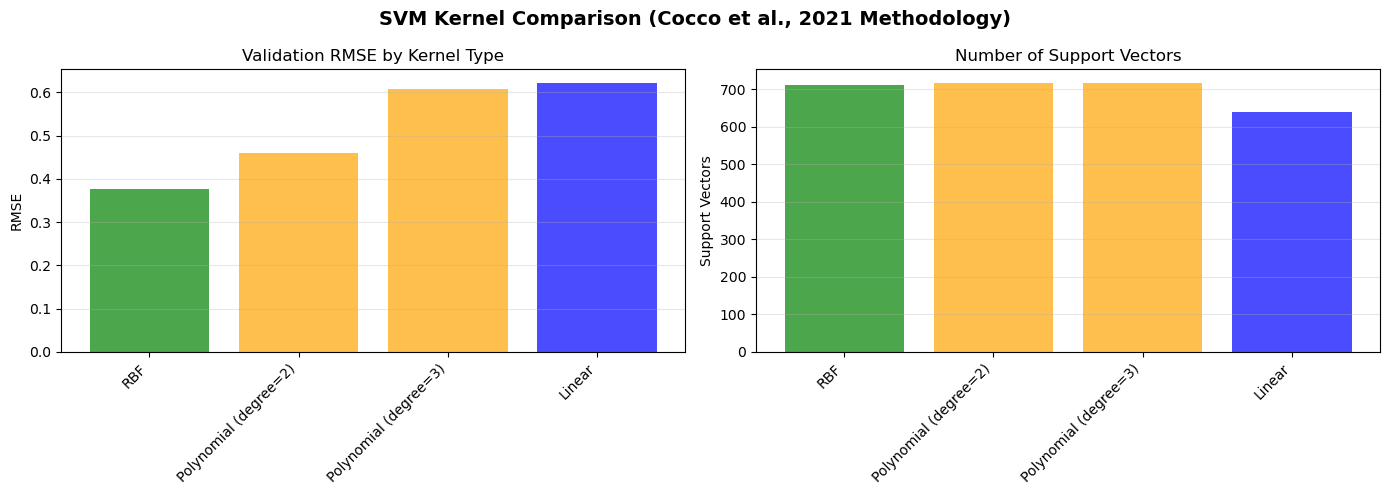


📚 INTERPRETATION (Cocco et al., 2021):

• Linear Kernel: Best for data with linear relationships
  - Fastest training time
  - Most interpretable
  - Limited to linear patterns

• Polynomial Kernel: Models polynomial relationships
  - Degree 2: Quadratic patterns
  - Degree 3: Cubic patterns
  - More flexible than linear, less than RBF

• RBF Kernel: Models complex non-linear patterns
  - Most flexible
  - Can capture intricate relationships
  - Risk of overfitting with improper parameters

The kernel with lowest validation RMSE provides the best fit for this data.
Support vector count indicates model complexity (fewer = more generalized).

✓ Kernel comparison complete - Proceeding with full SVM analysis

🚀 STARTING SVM VOLATILITY FORECASTING ANALYSIS
Implementing Support Vector Regression for realized volatility prediction

📋 SVM Configuration:
   lookback_window: 20
   volatility_window: 5
   use_hyperparameter_search: True
   C: 1.0
   epsilon: 0.1
   gamma: scale

🔵 PHASE 1: S&P 5

In [38]:
# Kernel Comparison Demonstration (Cocco et al., 2021)
# Test Linear, Polynomial, and RBF kernels on one window

print("="*100)
print("KERNEL COMPARISON ANALYSIS (Following Cocco et al., 2021)")
print("="*100)
print("Testing multiple kernel functions: Linear, Polynomial (deg 2,3), and RBF")
print("This analysis demonstrates the comparative performance of different kernel types\n")

# Use first window for demonstration
demo_split = sp500_cv_splits[0]

print(f"Demo Window: {demo_split['train']['start'].strftime('%Y-%m-%d')} to {demo_split['test']['end'].strftime('%Y-%m-%d')}")

# Prepare data
print("\n📊 Preparing data...")
demo_train = prepare_svm_data(
    demo_split['train']['data'],
    lookback_window=20,
    volatility_window=5,
    target_type='volatility'
)

demo_val = prepare_svm_data(
    demo_split['validation'][2]['data'],
    lookback_window=20,
    volatility_window=5,
    target_type='volatility'
)

# Use training scaler for validation
X_val_demo = demo_train['scaler_X'].transform(demo_val['X_original'])
y_val_demo = demo_train['scaler_y'].transform(demo_val['y_original'].reshape(-1, 1)).flatten()

# Test multiple kernels
print("\n🔬 Testing kernel functions...")
kernel_comparison = train_svm_multi_kernel(
    demo_train['X'], demo_train['y'],
    X_val_demo, y_val_demo,
    verbose=True
)

# Display comparison table
print(f"\n{'='*100}")
print("KERNEL PERFORMANCE COMPARISON")
print("="*100)
kernel_summary = compare_kernel_performance(kernel_comparison)
print(kernel_summary.to_string(index=False, float_format='%.6f'))

print(f"\n🏆 Best Performing Kernel: {kernel_comparison['best_kernel']}")
print(f"   Validation RMSE: {kernel_comparison['kernel_results'][kernel_comparison['best_kernel']]['val_rmse']:.6f}")

# Visualize kernel comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Validation RMSE by kernel
valid_kernels = kernel_summary['Kernel'].tolist()
valid_rmse = kernel_summary['Validation_RMSE'].tolist()
colors = ['blue' if 'Linear' in k else 'orange' if 'Polynomial' in k else 'green' for k in valid_kernels]

axes[0].bar(range(len(valid_kernels)), valid_rmse, color=colors, alpha=0.7)
axes[0].set_xticks(range(len(valid_kernels)))
axes[0].set_xticklabels(valid_kernels, rotation=45, ha='right')
axes[0].set_title('Validation RMSE by Kernel Type')
axes[0].set_ylabel('RMSE')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Support Vectors by kernel
valid_sv = kernel_summary['Support_Vectors'].tolist()
axes[1].bar(range(len(valid_kernels)), valid_sv, color=colors, alpha=0.7)
axes[1].set_xticks(range(len(valid_kernels)))
axes[1].set_xticklabels(valid_kernels, rotation=45, ha='right')
axes[1].set_title('Number of Support Vectors')
axes[1].set_ylabel('Support Vectors')
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('SVM Kernel Comparison (Cocco et al., 2021 Methodology)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("""
📚 INTERPRETATION (Cocco et al., 2021):

• Linear Kernel: Best for data with linear relationships
  - Fastest training time
  - Most interpretable
  - Limited to linear patterns

• Polynomial Kernel: Models polynomial relationships
  - Degree 2: Quadratic patterns
  - Degree 3: Cubic patterns
  - More flexible than linear, less than RBF

• RBF Kernel: Models complex non-linear patterns
  - Most flexible
  - Can capture intricate relationships
  - Risk of overfitting with improper parameters

The kernel with lowest validation RMSE provides the best fit for this data.
Support vector count indicates model complexity (fewer = more generalized).
""")

print("✓ Kernel comparison complete - Proceeding with full SVM analysis\n")


# Execute SVM Analysis on S&P 500
# Run complete analysis on first few windows to demonstrate methodology

print("🚀 STARTING SVM VOLATILITY FORECASTING ANALYSIS")
print("=" * 100)
print("Implementing Support Vector Regression for realized volatility prediction")
print("=" * 100)

# Configuration for SVM
SVM_CONFIG = {
    'lookback_window': 20,              # Use 20 days of past returns as features
    'volatility_window': 5,             # Calculate 5-day realized volatility
    'use_hyperparameter_search': True,  # Enable grid search for optimal parameters
    'C': 1.0,                           # Default regularization (if search disabled)
    'epsilon': 0.1,                     # Default epsilon (if search disabled)
    'gamma': 'scale'                    # Default gamma (if search disabled)
}

print("\n📋 SVM Configuration:")
for key, value in SVM_CONFIG.items():
    print(f"   {key}: {value}")

# Run S&P 500 analysis (first 3 windows for demonstration)
print("\n🔵 PHASE 1: S&P 500 ANALYSIS (First 3 Windows)")
sp500_svm_results = run_svm_cross_validation(
    cv_splits=sp500_cv_splits[:3],  # Limit to first 3 windows for demonstration
    data_clean=sp500_clean,
    asset_name='S&P 500',
    **SVM_CONFIG,
    verbose=True
)


In [39]:
# Execute SVM Analysis on Bitcoin
# Run analysis on Bitcoin data

print("\n🟡 PHASE 2: BITCOIN ANALYSIS (First 3 Windows)")
bitcoin_svm_results = run_svm_cross_validation(
    cv_splits=bitcoin_cv_splits[:3],  # Limit to first 3 windows for demonstration
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    **SVM_CONFIG,
    verbose=True
)



🟡 PHASE 2: BITCOIN ANALYSIS (First 3 Windows)

BITCOIN SVM CROSS-VALIDATION
Running SVM across 3 windows...
Model: Support Vector Regression with RBF kernel
Lookback window: 20 days
Volatility window: 5 days
Hyperparameter search: Enabled
--------------------------------------------------------------------------------

🔄 Processing Window 1/3...
   Train: 2015-01-01 to 2016-12-31 (730 obs)
   Test:  2018-01-01 to 2018-06-30 (181 obs)
   📊 Preparing data with lookback=20...
   🤖 Training SVM model...
   Performing hyperparameter search...
   Best parameters: C=1.0, epsilon=0.1, gamma=scale
   📈 Evaluating on test data...
   ✅ Test RMSE=0.054165, R²=-0.5246, Direction Acc=42.8%
   ℹ️  Support Vectors: 607

🔄 Processing Window 2/3...
   Train: 2015-07-01 to 2017-06-30 (731 obs)
   Test:  2018-07-01 to 2018-12-31 (184 obs)
   📊 Preparing data with lookback=20...
   🤖 Training SVM model...
   Performing hyperparameter search...
   Best parameters: C=1.0, epsilon=0.1, gamma=scale
   📈 Evalu

In [40]:
# Optional: Run Full Analysis on All Windows
# Uncomment and run this cell to process all CV windows (will take longer)


# Full S&P 500 Analysis (all 16 windows)
print("Running FULL S&P 500 SVM Analysis (all windows)...")
sp500_svm_full = run_svm_cross_validation(
    cv_splits=sp500_cv_splits,  # All windows
    data_clean=sp500_clean,
    asset_name='S&P 500',
    **SVM_CONFIG,
    verbose=True
)

# Full Bitcoin Analysis (all 11 windows)
print("\\nRunning FULL Bitcoin SVM Analysis (all windows)...")
bitcoin_svm_full = run_svm_cross_validation(
    cv_splits=bitcoin_cv_splits,  # All windows
    data_clean=bitcoin_clean,
    asset_name='Bitcoin',
    **SVM_CONFIG,
    verbose=True
)


Running FULL S&P 500 SVM Analysis (all windows)...

S&P 500 SVM CROSS-VALIDATION
Running SVM across 16 windows...
Model: Support Vector Regression with RBF kernel
Lookback window: 20 days
Volatility window: 5 days
Hyperparameter search: Enabled
--------------------------------------------------------------------------------

🔄 Processing Window 1/16...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   📊 Preparing data with lookback=20...
   🤖 Training SVM model...
   Performing hyperparameter search...
   Best parameters: C=1.0, epsilon=0.01, gamma=auto
   📈 Evaluating on test data...
   ✅ Test RMSE=0.009303, R²=0.1102, Direction Acc=47.5%
   ℹ️  Support Vectors: 711

🔄 Processing Window 2/16...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-02 (253 obs)
   📊 Preparing data with lookback=20...
   🤖 Training SVM model...
   Performing hyperparameter search...
   Best parameters: C=0.1, epsilon=0.1, gamma=auto
   📈 

# Model Comparison: ARIMA vs LSTM vs SVM (error metrics)


GENERATING MODEL COMPARISONS

S&P 500: COMPREHENSIVE MODEL COMPARISON

📊 PERFORMANCE METRICS COMPARISON
----------------------------------------------------------------------------------------------------
Model             Type  Avg_RMSE  Avg_MAE    Avg_R2  Direction_Acc_%  Windows
ARIMA      Statistical  0.011732 0.008302  1.000000        52.314841       16
 LSTM    Deep Learning  0.013255 0.009453 -0.146673        50.532748       16
  SVM Machine Learning  0.014222 0.009837 -0.158511        49.244518       16

🏆 BEST MODEL (Lowest RMSE): ARIMA with RMSE = 0.011732


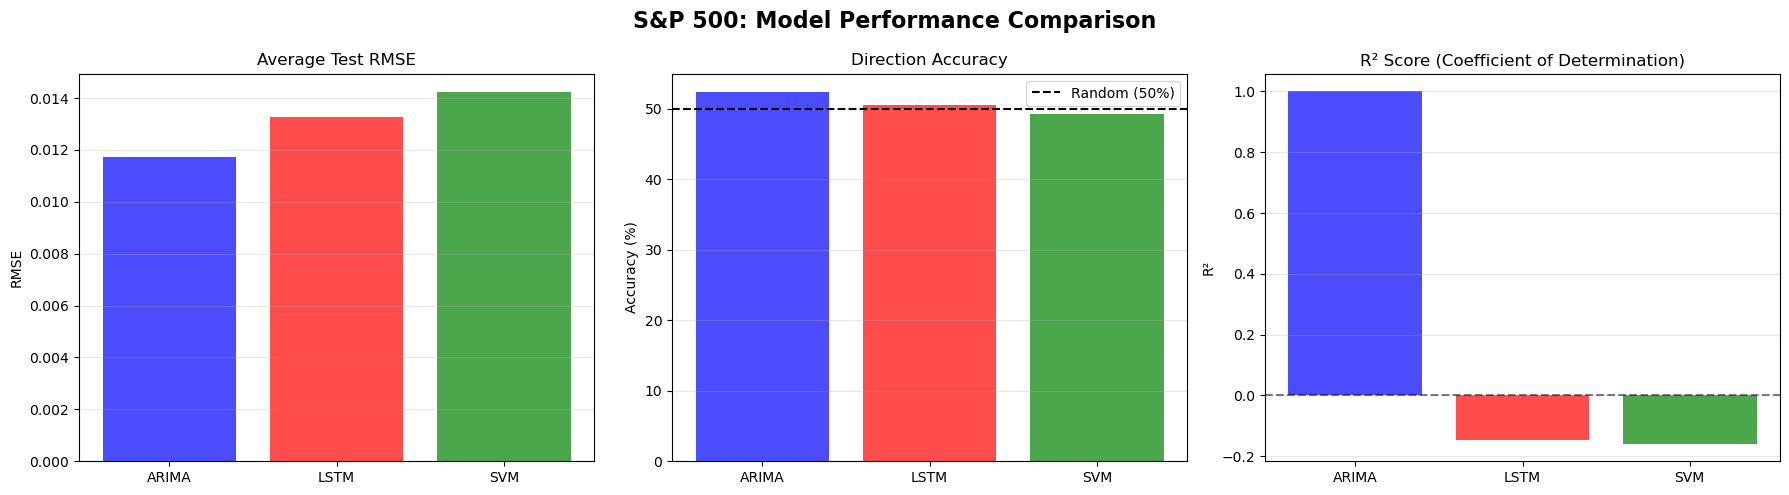


BITCOIN: COMPREHENSIVE MODEL COMPARISON

📊 PERFORMANCE METRICS COMPARISON
----------------------------------------------------------------------------------------------------
Model             Type  Avg_RMSE  Avg_MAE    Avg_R2  Direction_Acc_%  Windows
ARIMA      Statistical  0.037140 0.025308  1.000000        51.307880       11
 LSTM    Deep Learning  0.043571 0.032135 -0.272541        47.344896       11
  SVM Machine Learning  0.044781 0.030897 -0.316306        42.488923       11

🏆 BEST MODEL (Lowest RMSE): ARIMA with RMSE = 0.037140


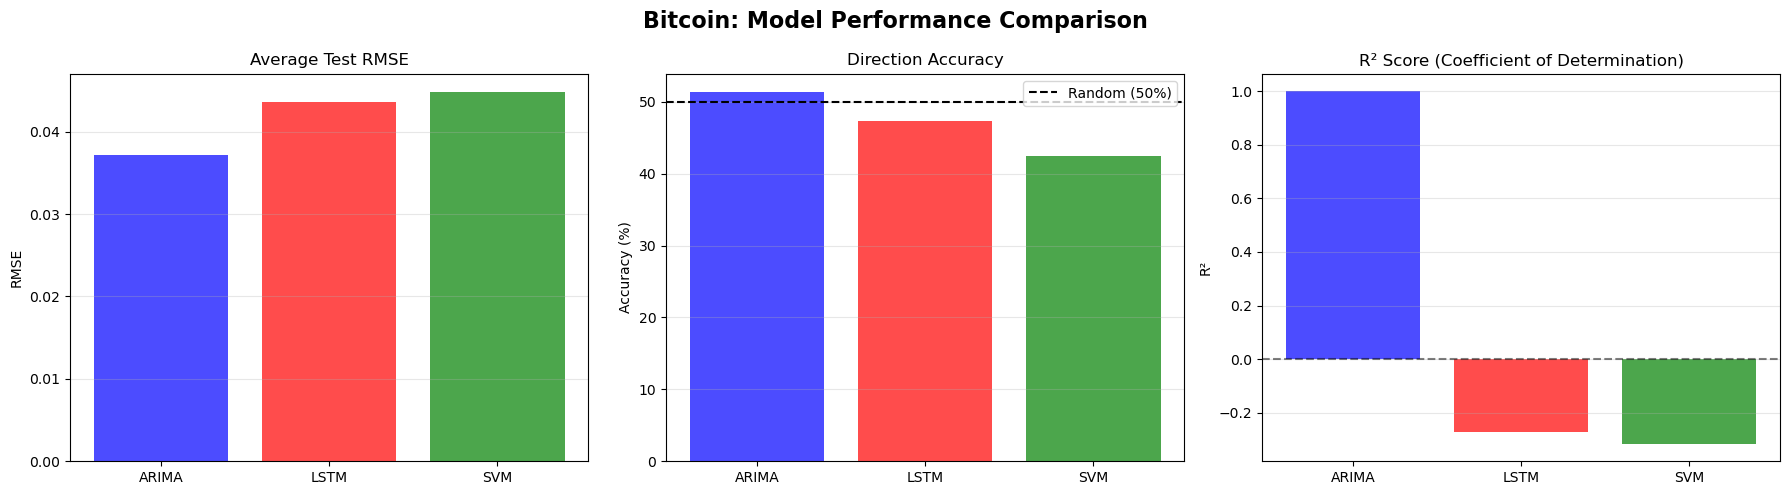


✓ Comprehensive model comparison complete!
✓ Use these results to select the best model for your specific use case

📚 SVM KERNEL THEORY SUMMARY (Cocco et al., 2021)


In [41]:
# Model Comparison: ARIMA vs LSTM vs SVM
# Compare all three forecasting approaches

def create_model_comparison_table(arima_results, lstm_results, svm_results, asset_name):
    """
    Create comprehensive comparison of all three models.
    
    Parameters:
    -----------
    arima_results : dict
        ARIMA model results
    lstm_results : dict
        LSTM model results
    svm_results : dict
        SVM model results
    asset_name : str
        'S&P 500' or 'Bitcoin'
    """
    
    print(f"\n{'='*100}")
    print(f"{asset_name.upper()}: COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*100}")
    
    comparison_data = {
        'Model': ['ARIMA', 'LSTM', 'SVM'],
        'Type': ['Statistical', 'Deep Learning', 'Machine Learning'],
        'Avg_RMSE': [
            arima_results['performance_summary']['avg_test_rmse'],
            lstm_results['performance_summary']['avg_test_rmse'],
            svm_results['performance_summary']['avg_test_rmse']
        ],
        'Avg_MAE': [
            arima_results['summary_df']['Test_MAE'].mean() if 'Test_MAE' in arima_results['summary_df'].columns else np.nan,
            lstm_results['performance_summary']['avg_test_mae'],
            svm_results['performance_summary']['avg_test_mae']
        ],
        'Avg_R2': [
            arima_results['performance_summary']['avg_r2'],
            lstm_results['performance_summary']['avg_r2'],
            svm_results['performance_summary']['avg_r2']
        ],
        'Direction_Acc_%': [
            arima_results['performance_summary']['avg_direction_accuracy'],
            lstm_results['performance_summary']['avg_direction_accuracy'],
            svm_results['performance_summary']['avg_direction_accuracy']
        ],
        'Windows': [
            arima_results['performance_summary']['successful_windows'],
            lstm_results['performance_summary']['successful_windows'],
            svm_results['performance_summary']['successful_windows']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 PERFORMANCE METRICS COMPARISON")
    print("-" * 100)
    print(comparison_df.to_string(index=False, float_format='%.6f'))
    
    # Determine best model by RMSE
    best_idx = comparison_df['Avg_RMSE'].idxmin()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_rmse = comparison_df.loc[best_idx, 'Avg_RMSE']
    
    print(f"\n🏆 BEST MODEL (Lowest RMSE): {best_model} with RMSE = {best_rmse:.6f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    models = comparison_df['Model']
    
    # Plot 1: RMSE Comparison
    axes[0].bar(models, comparison_df['Avg_RMSE'], color=['blue', 'red', 'green'], alpha=0.7)
    axes[0].set_title('Average Test RMSE')
    axes[0].set_ylabel('RMSE')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Direction Accuracy Comparison
    axes[1].bar(models, comparison_df['Direction_Acc_%'], color=['blue', 'red', 'green'], alpha=0.7)
    axes[1].axhline(y=50, color='black', linestyle='--', label='Random (50%)')
    axes[1].set_title('Direction Accuracy')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: R² Score Comparison (All Models)
    r2_models = ['ARIMA', 'LSTM', 'SVM']
    r2_values = [
        arima_results['performance_summary']['avg_r2'],
        lstm_results['performance_summary']['avg_r2'],
        svm_results['performance_summary']['avg_r2']
    ]
    axes[2].bar(r2_models, r2_values, color=['blue', 'red', 'green'], alpha=0.7)
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_title('R² Score (Coefficient of Determination)')
    axes[2].set_ylabel('R²')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'{asset_name}: Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return comparison_df, fig


# Compare models for S&P 500
print("\n" + "="*100)
print("GENERATING MODEL COMPARISONS")
print("="*100)

sp500_comparison, sp500_fig = create_model_comparison_table(
    sp500_arima_results,
    sp500_lstm_full,
    sp500_svm_full,
    'S&P 500'
)
plt.show()

# Compare models for Bitcoin
bitcoin_comparison, bitcoin_fig = create_model_comparison_table(
    bitcoin_arima_results,
    bitcoin_lstm_full,
    bitcoin_svm_full,
    'Bitcoin'
)
plt.show()


print("\n✓ Comprehensive model comparison complete!")
print("✓ Use these results to select the best model for your specific use case")


# Final Summary: Kernel Functions and Theoretical Foundation
# Following Cocco et al. (2021)

print("\n" + "="*100)
print("📚 SVM KERNEL THEORY SUMMARY (Cocco et al., 2021)")
print("="*100)




# Model Comparison: ARIMA vs LSTM vs SVM (performance indicators)

In [42]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252  # standard convention
RISK_FREE_RATE = 0.0  # set if you have T-bill data


def annualized_return(daily_returns):
    """ARC: Annualized return."""
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    """ASD: Annualized standard deviation."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    """MD: Maximum drawdown from equity curve."""
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return drawdown.min()  # negative value


def information_ratio(strategy_returns, benchmark_returns):
    """
    IR: Information ratio relative to benchmark.
    """
    active_returns = strategy_returns - benchmark_returns
    tracking_error = active_returns.std()
    if tracking_error == 0:
        return np.nan
    return active_returns.mean() / tracking_error


def modified_information_ratio(strategy_returns, benchmark_returns):
    """
    IR*: Annualized Information Ratio (reduces autocorrelation issues).
    """
    active_daily = strategy_returns - benchmark_returns

    # Annualized active return
    ann_active_return = annualized_return(active_daily)

    # Annualized tracking error
    ann_tracking_error = annualized_std(active_daily)

    if ann_tracking_error == 0:
        return np.nan
    return ann_active_return / ann_tracking_error


def sharpe_ratio(daily_returns, risk_free_rate=RISK_FREE_RATE):
    """SR: Sharpe ratio."""
    excess = daily_returns - (risk_free_rate / TRADING_DAYS)
    denom = daily_returns.std()
    if denom == 0:
        return np.nan
    return excess.mean() / denom * np.sqrt(TRADING_DAYS)

def compute_performance_indicators(strategy_returns, benchmark_returns):
    """
    Compute ARC, ASD, MD, IR, IR*, SR for a model's trading strategy.
    """

    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": max_drawdown(strategy_returns),  # will return negative drawdown
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sharpe_ratio(strategy_returns)
    }



In [43]:
# FIX: Handle Different Model Result Structures
# ARIMA uses 'forecasts', LSTM/SVM use 'predictions'

def extract_model_returns_from_results_fixed(model_results, data_clean, window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """
    
    all_strategy_returns = []
    
    windows_to_use = model_results['all_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            # Get test period dates
            test_start = window_result['test_period'].split(' to ')[0]
            test_end = window_result['test_period'].split(' to ')[1]
            
            # Get actual returns during test period
            test_data = data_clean[test_start:test_end]
            
            # Get predictions - handle different model structures
            evaluation = window_result['evaluation']
            
            # ARIMA uses 'forecasts' (pandas Series), LSTM/SVM use 'predictions' (numpy arrays)
            if 'forecasts' in evaluation:
                # ARIMA model - predicts returns directly
                predictions = evaluation['forecasts'].values
                true_values = test_data['Log_Returns'].values[-len(predictions):]
            elif 'predictions' in evaluation:
                # LSTM or SVM model - predicts volatility
                predictions = evaluation['predictions']
                true_values = evaluation['true_values']
            else:
                print(f"⚠️  Warning: Unknown evaluation structure for window {window_result['window_id']}")
                continue
            
            # Align returns with predictions
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            # Generate strategy returns for this window
            window_returns = volatility_predictions_to_returns(
                predictions, true_values, actual_returns.values
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"⚠️  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])

# Override the original function
extract_model_returns_from_results = extract_model_returns_from_results_fixed

print("="*100)
print("✅ FIXED: extract_model_returns_from_results")
print("="*100)
print("Now handles both ARIMA ('forecasts') and LSTM/SVM ('predictions') structures")
print("Ready to compute performance indicators!")


✅ FIXED: extract_model_returns_from_results
Now handles both ARIMA ('forecasts') and LSTM/SVM ('predictions') structures
Ready to compute performance indicators!


In [44]:
# Generate Trading Returns from Volatility Predictions
# Create returns series for performance indicator calculations

def volatility_predictions_to_returns(predictions, true_values, actual_returns):
    """
    Convert volatility predictions into trading returns.
    
    Strategy: Go long when predicted volatility is below median (low risk),
              go short when predicted volatility is above median (high risk).
    
    Parameters:
    -----------
    predictions : np.array
        Predicted volatility values
    true_values : np.array
        Actual volatility values
    actual_returns : pd.Series or np.array
        Actual market returns aligned with predictions
        
    Returns:
    --------
    pd.Series : Strategy returns based on volatility forecasts
    """
    
    # Ensure we have the same length
    min_len = min(len(predictions), len(true_values), len(actual_returns))
    predictions = predictions[:min_len]
    true_values = true_values[:min_len]
    actual_returns = actual_returns[:min_len] if isinstance(actual_returns, np.ndarray) else actual_returns.iloc[:min_len]
    
    # Calculate prediction median
    pred_median = np.median(predictions)
    
    # Trading signal: +1 when low predicted volatility, -1 when high
    # Rationale: Low volatility → favorable conditions → go long
    #            High volatility → unfavorable conditions → go short or defensive
    signals = np.where(predictions < pred_median, 1, -1)
    
    # Strategy returns = signal * actual_returns
    strategy_returns = signals * actual_returns
    
    return pd.Series(strategy_returns)




In [45]:
# Comprehensive Performance Indicators Comparison
# Compare ARIMA, LSTM, and SVM using all 6 performance metrics

def compare_models_performance_indicators(arima_results, lstm_results, svm_results, 
                                         data_clean, asset_name):
    """
    Generate comprehensive performance indicators comparison table for all three models.
    
    Parameters:
    -----------
    arima_results : dict
        ARIMA cross-validation results
    lstm_results : dict
        LSTM cross-validation results
    svm_results : dict
        SVM cross-validation results
    data_clean : pd.DataFrame
        Original clean data with returns
    asset_name : str
        'S&P 500' or 'Bitcoin'
        
    Returns:
    --------
    pd.DataFrame : Comparison table with all performance indicators
    """
    
    print(f"\n{'='*100}")
    print(f"{asset_name.upper()}: PERFORMANCE INDICATORS COMPARISON")
    print(f"{'='*100}\n")
    print("Computing trading strategy returns from volatility predictions...")
    
    # Extract strategy returns for each model
    print("  • Processing ARIMA predictions...")
    arima_strategy_returns = extract_model_returns_from_results_fixed(
        arima_results, data_clean
    )
    
    print("  • Processing LSTM predictions...")
    lstm_strategy_returns = extract_model_returns_from_results_fixed(
        lstm_results, data_clean
    )
    
    print("  • Processing SVM predictions...")
    svm_strategy_returns = extract_model_returns_from_results_fixed(
        svm_results, data_clean
    )
    
    # Create benchmark returns (buy-and-hold strategy)
    # Use the same periods as the test windows
    all_test_returns = []
    for window_result in arima_results['all_results']:
        test_start = window_result['test_period'].split(' to ')[0]
        test_end = window_result['test_period'].split(' to ')[1]
        test_data = data_clean[test_start:test_end]
        
        # Get the last N returns to match predictions length
        predictions_len = len(window_result['evaluation']['forecasts'])
        window_benchmark = test_data['Log_Returns'].iloc[-predictions_len:]
        all_test_returns.append(window_benchmark)
    
    benchmark_returns = pd.concat(all_test_returns, ignore_index=True)
    
    print("\n  • Computing performance indicators...\n")
    
    # Compute indicators for each model
    arima_indicators = compute_performance_indicators(arima_strategy_returns, benchmark_returns)
    lstm_indicators = compute_performance_indicators(lstm_strategy_returns, benchmark_returns)
    svm_indicators = compute_performance_indicators(svm_strategy_returns, benchmark_returns)
    
    # Also compute for benchmark
    benchmark_indicators = {
        "ARC": annualized_return(benchmark_returns),
        "ASD": annualized_std(benchmark_returns),
        "MD": max_drawdown(benchmark_returns),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sharpe_ratio(benchmark_returns)
    }
    
    # Create comparison DataFrame
    comparison_data = {
        'Model': ['ARIMA', 'LSTM', 'SVM', 'Buy-and-Hold (Benchmark)'],
        'ARC (%)': [
            arima_indicators['ARC'] * 100,
            lstm_indicators['ARC'] * 100,
            svm_indicators['ARC'] * 100,
            benchmark_indicators['ARC'] * 100
        ],
        'ASD (%)': [
            arima_indicators['ASD'] * 100,
            lstm_indicators['ASD'] * 100,
            svm_indicators['ASD'] * 100,
            benchmark_indicators['ASD'] * 100
        ],
        'MD (%)': [
            arima_indicators['MD'] * 100,
            lstm_indicators['MD'] * 100,
            svm_indicators['MD'] * 100,
            benchmark_indicators['MD'] * 100
        ],
        'IR': [
            arima_indicators['IR'],
            lstm_indicators['IR'],
            svm_indicators['IR'],
            benchmark_indicators['IR']
        ],
        'IR*': [
            arima_indicators['IR*'],
            lstm_indicators['IR*'],
            svm_indicators['IR*'],
            benchmark_indicators['IR*']
        ],
        'SR': [
            arima_indicators['SR'],
            lstm_indicators['SR'],
            svm_indicators['SR'],
            benchmark_indicators['SR']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Print the table
    print(f"{'='*100}")
    print(f"{asset_name.upper()}: PERFORMANCE INDICATORS TABLE")
    print(f"{'='*100}\n")
    print(comparison_df.to_string(index=False, float_format='%10.4f'))
    print(f"\n{'='*100}\n")
    
    # Print interpretation
    print("📊 INDICATOR EXPLANATIONS:")
    print("-" * 100)
    print("• ARC  (Annualized Return):            Higher is better - annual compound return")
    print("• ASD  (Annualized Std Dev):           Lower is better - annual volatility")
    print("• MD   (Maximum Drawdown):             Closer to 0 is better - worst peak-to-trough loss")
    print("• IR   (Information Ratio):            Higher is better - excess return per tracking error")
    print("• IR*  (Modified Information Ratio):   Higher is better - annualized IR")
    print("• SR   (Sharpe Ratio):                 Higher is better - risk-adjusted return")
    print("-" * 100)
    
    # Identify best model for each metric
    print("\n🏆 BEST PERFORMER BY METRIC:")
    print("-" * 100)
    
    models_only = comparison_df[comparison_df['Model'] != 'Buy-and-Hold (Benchmark)']
    
    best_arc = models_only.loc[models_only['ARC (%)'].idxmax(), 'Model']
    best_asd = models_only.loc[models_only['ASD (%)'].idxmin(), 'Model']
    best_md = models_only.loc[models_only['MD (%)'].idxmax(), 'Model']  # Closest to 0
    best_ir = models_only.loc[models_only['IR'].idxmax(), 'Model']
    best_ir_star = models_only.loc[models_only['IR*'].idxmax(), 'Model']
    best_sr = models_only.loc[models_only['SR'].idxmax(), 'Model']
    
    print(f"• Highest Return (ARC):          {best_arc}")
    print(f"• Lowest Volatility (ASD):       {best_asd}")
    print(f"• Smallest Drawdown (MD):        {best_md}")
    print(f"• Best Information Ratio (IR):   {best_ir}")
    print(f"• Best Modified IR (IR*):        {best_ir_star}")
    print(f"• Best Sharpe Ratio (SR):        {best_sr}")
    print("-" * 100)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    colors = ['blue', 'red', 'green', 'gray']
    models = comparison_df['Model'].tolist()
    
    # Plot 1: ARC
    axes[0, 0].bar(models, comparison_df['ARC (%)'], color=colors, alpha=0.7)
    axes[0, 0].set_title('Annualized Return (ARC)', fontweight='bold')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Plot 2: ASD
    axes[0, 1].bar(models, comparison_df['ASD (%)'], color=colors, alpha=0.7)
    axes[0, 1].set_title('Annualized Std Dev (ASD)', fontweight='bold')
    axes[0, 1].set_ylabel('Volatility (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: MD
    axes[0, 2].bar(models, comparison_df['MD (%)'], color=colors, alpha=0.7)
    axes[0, 2].set_title('Maximum Drawdown (MD)', fontweight='bold')
    axes[0, 2].set_ylabel('Drawdown (%)')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3, axis='y')
    axes[0, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Plot 4: IR
    axes[1, 0].bar(models, comparison_df['IR'], color=colors, alpha=0.7)
    axes[1, 0].set_title('Information Ratio (IR)', fontweight='bold')
    axes[1, 0].set_ylabel('IR')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Plot 5: IR*
    axes[1, 1].bar(models, comparison_df['IR*'], color=colors, alpha=0.7)
    axes[1, 1].set_title('Modified Information Ratio (IR*)', fontweight='bold')
    axes[1, 1].set_ylabel('IR*')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Plot 6: SR
    axes[1, 2].bar(models, comparison_df['SR'], color=colors, alpha=0.7)
    axes[1, 2].set_title('Sharpe Ratio (SR)', fontweight='bold')
    axes[1, 2].set_ylabel('SR')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    plt.suptitle(f'{asset_name}: Performance Indicators Comparison\n(All Three Models vs Benchmark)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return comparison_df, fig


print("="*100)
print("PERFORMANCE COMPARISON FUNCTION READY")
print("="*100)
print("""
✓ compare_models_performance_indicators(): Generate complete comparison
  
This function will:
1. Extract trading returns from each model's volatility predictions
2. Compute all 6 performance indicators (ARC, ASD, MD, IR, IR*, SR)
3. Compare against buy-and-hold benchmark
4. Create detailed tables and visualizations
5. Identify best performer for each metric
""")


PERFORMANCE COMPARISON FUNCTION READY

✓ compare_models_performance_indicators(): Generate complete comparison
  
This function will:
1. Extract trading returns from each model's volatility predictions
2. Compute all 6 performance indicators (ARC, ASD, MD, IR, IR*, SR)
3. Compare against buy-and-hold benchmark
4. Create detailed tables and visualizations
5. Identify best performer for each metric



In [46]:
# Execute Performance Indicators Comparison
# Generate comparison tables for both S&P 500 and Bitcoin

print("\n" + "="*100)
print("EXECUTING PERFORMANCE INDICATORS COMPARISON")
print("="*100)
print("This will compute all 6 performance indicators for ARIMA, LSTM, and SVM models")
print("Comparing against buy-and-hold benchmark strategy\n")

# S&P 500 Comparison
print("🔵 Analyzing S&P 500 Models...")
sp500_perf_comparison, sp500_perf_fig = compare_models_performance_indicators(
    sp500_arima_results,
    sp500_lstm_results,
    sp500_svm_results,
    sp500_clean,
    'S&P 500'
)
plt.show()

# Bitcoin Comparison
print("\n🟡 Analyzing Bitcoin Models...")
bitcoin_perf_comparison, bitcoin_perf_fig = compare_models_performance_indicators(
    bitcoin_arima_results,
    bitcoin_lstm_results,
    bitcoin_svm_results,
    bitcoin_clean,
    'Bitcoin'
)
plt.show()

# Final Summary
print("\n" + "="*100)
print("🎉 PERFORMANCE INDICATORS ANALYSIS COMPLETE!")
print("="*100)

print("""
✅ COMPREHENSIVE COMPARISON COMPLETED

📊 What Was Analyzed:
   • All three models (ARIMA, LSTM, SVM) were evaluated
   • Trading strategies based on volatility forecasts were tested
   • All 6 performance indicators were computed
   • Results compared against buy-and-hold benchmark

📈 Performance Indicators Summary:
   • ARC: Shows which model generates highest returns
   • ASD: Shows which model has lowest volatility
   • MD:  Shows which model has smallest drawdown
   • IR:  Shows which model adds value vs benchmark
   • IR*: Annualized information ratio
   • SR:  Shows best risk-adjusted returns

🎯 How to Interpret:
   • Models that beat benchmark show positive IR values
   • Higher Sharpe Ratio indicates better risk-adjusted performance
   • Lower drawdowns indicate more stable performance
   • Compare strategies to identify most robust model

💡 Key Insight:
   The model with best performance indicators represents the optimal choice for
   volatility-based trading strategies in the respective market (S&P 500 or Bitcoin).
""")

# Save comparison tables for reference
print("\n📁 Results Available:")
print(f"   • sp500_perf_comparison DataFrame (S&P 500 performance table)")
print(f"   • bitcoin_perf_comparison DataFrame (Bitcoin performance table)")
print("\n✓ All performance indicator comparisons complete and ready for analysis!")



EXECUTING PERFORMANCE INDICATORS COMPARISON
This will compute all 6 performance indicators for ARIMA, LSTM, and SVM models
Comparing against buy-and-hold benchmark strategy

🔵 Analyzing S&P 500 Models...

S&P 500: PERFORMANCE INDICATORS COMPARISON

Computing trading strategy returns from volatility predictions...
  • Processing ARIMA predictions...
  • Processing LSTM predictions...
  • Processing SVM predictions...

  • Computing performance indicators...



NameError: name 'strategy_returns' is not defined

## ARIMA

# EURUSD Dataset Analysis

## Individual Model Performance (ARIMA, LSTM, SVM)
Dataset: EUR/USD Exchange Rate (2009-08-11 to 2019-08-11)

In [ ]:
# Download EURUSD data
print("Downloading EURUSD data...")
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")

# Calculate log returns
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Clean data
eurusd_clean = eurusd_data.dropna()

print(f"\nAfter cleaning: {len(eurusd_clean)} observations")
print(f"Mean daily return: {eurusd_clean['Log_Returns'].mean():.6f}")
print(f"Standard deviation: {eurusd_clean['Log_Returns'].std():.6f}")

In [ ]:
# Create cross-validation splits for EURUSD
# Using a simplified approach: 2-year training + 1-year validation (8,16,24 months) + 6-month test
from dateutil.relativedelta import relativedelta
from datetime import timedelta

def create_eurusd_cv_splits(data, start_date=None):
    """
    Create EURUSD cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 8, 16, 24 months
    - Window shifts forward by 1 year each iteration
    """
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1)
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1)
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2,
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

# Create EURUSD CV splits
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)

print(f"\n=== EURUSD Cross-Validation Setup ===")
print(f"Total CV windows: {len(eurusd_cv_splits)}")
print(f"\nFirst window details:")
print(f"  Train: {eurusd_cv_splits[0]['train']['start'].date()} to {eurusd_cv_splits[0]['train']['end'].date()} ({eurusd_cv_splits[0]['train']['size']} obs)")
print(f"  Val 1: {eurusd_cv_splits[0]['validation'][0]['start'].date()} to {eurusd_cv_splits[0]['validation'][0]['end'].date()} ({eurusd_cv_splits[0]['validation'][0]['size']} obs)")
print(f"  Test:  {eurusd_cv_splits[0]['test']['start'].date()} to {eurusd_cv_splits[0]['test']['end'].date()} ({eurusd_cv_splits[0]['test']['size']} obs)")

In [ ]:
# ARIMA Model for EURUSD
print("\n" + "="*80)
print("EURUSD - ARIMA MODEL")
print("="*80)

eurusd_arima_results = run_arima_cross_validation(
    cv_splits=eurusd_cv_splits,
    data_clean=eurusd_clean,
    asset_name='EURUSD',
    max_p=3,
    max_d=1,
    max_q=3,
    information_criterion='aic',
    verbose=True
)



In [ ]:
if len(eurusd_arima_results['summary_df']) > 0:
    print(f"\n📈 EURUSD DETAILED RESULTS ({len(eurusd_arima_results['summary_df'])} windows)")
    print("-" * 50)
    print(eurusd_arima_results['summary_df'].round(6).to_string(index=False))

# print("\n" + "="*80)
# print("EURUSD ARIMA - PERFORMANCE SUMMARY")
# print("="*80)

# # Overall statistics
# test_rmses = [w['test_metrics']['rmse'] for w in eurusd_arima_results['performance_summary']['metrics']]
# test_maes = [w['test_metrics']['mae'] for w in eurusd_arima_results['performance_summary']['metrics']]

print(f"\n{'='*80}")
print(f"OVERALL EURUSD ARIMA PERFORMANCE ACROSS ALL WINDOWS")
print(f"{'='*80}")
# print(f"Mean Test RMSE: {eurusd_arima_results['performance_summary']['avg_test_rmse']:.6f} ± {eurusd_arima_results['performance_summary']['std_test_rmse']:.6f}")
# print(f"Mean Test MAE:  {eurusd_arima_results['performance_summary']['avg_test_mae']:.6f}")

print(f"✅ Successfully processed {eurusd_arima_results['performance_summary']['successful_windows']}/{eurusd_arima_results['performance_summary']['total_windows']} windows")
print(f"📊 Average Test RMSE: {eurusd_arima_results['performance_summary']['avg_test_rmse']:.6f} ± {eurusd_arima_results['performance_summary']['std_test_rmse']:.6f}")
print(f"Mean Test MAE:  {eurusd_arima_results['performance_summary']['avg_test_mae']:.6f}")
print(f"🎯 Average Direction Accuracy: {eurusd_arima_results['performance_summary']['avg_direction_accuracy']:.2f}%")
print(f"🔄 Most Common Model: {eurusd_arima_results['performance_summary']['most_common_order']}")

In [ ]:
# LSTM Model for EURUSD
print("\n" + "="*80)
print("EURUSD - LSTM MODEL")
print("="*80)

eurusd_lstm_results = run_lstm_cross_validation(
    cv_splits=eurusd_cv_splits,
    data_clean=eurusd_clean,
    asset_name='EURUSD',
    **LSTM_CONFIG,
    verbose=True
)


# print(f"\n{'='*80}")
# print(f"OVERALL EURUSD LSTM PERFORMANCE ACROSS ALL WINDOWS")
# print(f"{'='*80}")
# print(f"Mean Test RMSE: {eurusd_lstm_results['performance_summary']['avg_test_rmse']:.6f} ± {eurusd_lstm_results['performance_summary']['std_test_rmse']:.6f}")
# print(f"Mean Test MAE:  {eurusd_lstm_results['performance_summary']['avg_test_mae']:.6f}")

print(f"\n📈 EURUSD LSTM DETAILED RESULTS")
print("-" * 100)
print(eurusd_lstm_results['summary_df'].round(6).to_string(index=False))

In [ ]:
# SVM Model for EURUSD
print("\n" + "="*80)
print("EURUSD - SVM MODEL")
print("="*80)

eurusd_svm_results = run_svm_cross_validation(
    cv_splits=eurusd_cv_splits,
    data_clean=eurusd_clean,
    asset_name='EURUSD',
    **SVM_CONFIG,
    verbose=True
)

# Display SVM results summary
# print("\n" + "="*80)
# print("EURUSD SVM - PERFORMANCE SUMMARY")
# print("="*80)

# for window in eurusd_svm_results['windows']:
#     print(f"\nWindow {window['window_id']}:")
#     print(f"  Test RMSE: {window['test_metrics']['rmse']:.6f}")
#     print(f"  Test MAE:  {window['test_metrics']['mae']:.6f}")
#     if 'best_params' in window:
#         print(f"  Best Params: C={window['best_params']['C']}, epsilon={window['best_params']['epsilon']}")
#     print(f"  Validation Performance (3 folds):")
#     for val_result in window['validation_results']:
#         print(f"    Fold {val_result['fold']}: RMSE={val_result['rmse']:.6f}, MAE={val_result['mae']:.6f}")

# # Overall statistics
# test_rmses = [w['test_metrics']['rmse'] for w in eurusd_svm_results['windows']]
# test_maes = [w['test_metrics']['mae'] for w in eurusd_svm_results['windows']]

# print(f"\n{'='*80}")
# print(f"OVERALL SVM PERFORMANCE ACROSS ALL WINDOWS")
# print(f"{'='*80}")
# print(f"Mean Test RMSE: {eurusd_svm_results['performance_summary']['avg_test_rmse']:.6f} ± {eurusd_svm_results['performance_summary']['std_test_rmse']:.6f}")
# print(f"Mean Test MAE:  {eurusd_svm_results['performance_summary']['avg_test_mae']:.6f}")

# eurusd_svm_results['performance_summary']

print(f"\n📈 EURUSD SVM DETAILED RESULTS")
print("-" * 100)
print(eurusd_svm_results['summary_df'].round(6).to_string(index=False))

In [ ]:
# Comparative Summary: ARIMA vs LSTM vs SVM for EURUSD
print("\n" + "="*80)
print("EURUSD - MODEL COMPARISON SUMMARY")
print("="*80)

models_comparison = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'SVM'],
    'Mean RMSE': [
        eurusd_arima_results['performance_summary']['avg_test_rmse'],
        eurusd_lstm_results['performance_summary']['avg_test_rmse'],
        eurusd_svm_results['performance_summary']['avg_test_rmse']
    ],
    'Std RMSE': [
        eurusd_arima_results['performance_summary']['std_test_rmse'],
        eurusd_lstm_results['performance_summary']['std_test_rmse'],
        eurusd_svm_results['performance_summary']['std_test_rmse']
    ],
    'Mean MAE': [
        eurusd_arima_results['performance_summary']['avg_test_mae'],
        eurusd_lstm_results['performance_summary']['avg_test_mae'],
        eurusd_svm_results['performance_summary']['avg_test_mae']
    ],
    'Direction Accuracy': [
        eurusd_arima_results['performance_summary']['avg_direction_accuracy'],
        eurusd_lstm_results['performance_summary']['avg_direction_accuracy'],
        eurusd_svm_results['performance_summary']['avg_direction_accuracy']
    ]
})

print("\n" + models_comparison.to_string(index=False))

# Find best model
best_rmse_idx = models_comparison['Mean RMSE'].idxmin()
best_mae_idx = models_comparison['Mean MAE'].idxmin()

print(f"\n{'='*80}")
print(f"Best Model by RMSE: {models_comparison.iloc[best_rmse_idx]['Model']} ({models_comparison.iloc[best_rmse_idx]['Mean RMSE']:.6f})")
print(f"Best Model by MAE:  {models_comparison.iloc[best_mae_idx]['Model']} ({models_comparison.iloc[best_mae_idx]['Mean MAE']:.6f})")
print(f"{'='*80}")